In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import math

plt.style.use('ggplot')

読み込みファイル，計算に使用するデータ数，モンテカルロステップ数`T`，逆温度$\beta$(配列),モンテカルロサンプル数`sample`を指定．

`epsilon` と `length` は今後の計算に必要．

In [2]:
data_file = 'TAP_artificial_data_De=1.5_ka=20_kd=5_sigma=5e-6_1-10^4ms.dat'
data_points = 10
T = 10
sample = 1
#model = 0.1*np.arange(0, 11, 2, dtype=float)
#model = 0.1*np.arange(0, 11, dtype=float)
#model = 0.01*np.arange(0, 101, 5, dtype=float)
#print(model)


temp = np.array([1., 2., 10.])
beta= 1/temp

# true_diffusivity = 1.5
# true_k_a = 20.0
# true_k_d = 5.0
# true_standard_deviation = 5e-6
epsilon = 1.0
length = 35.0

## 2つのモデル

$M=0$ : 拡散のみ

* Dimensionless form

\begin{align}
    &\frac{\partial \bar{C}_{A}}{\partial \tau} = \frac{\partial^{2} \bar{C}_{A}}{\partial \xi^{2}} \\
    \Longrightarrow\, &\bar{F}_{A} = \sum_{n=0}^{\infty}\left(-1\right)^{n}\left(2n+1\right)\exp \left(-\left(n+\frac{1}{2}\right)^{2}\pi^{2}\tau\right)
\end{align}

$M=1$ : 拡散+吸着+脱離

* Dimensionless form

\begin{align}
    &\frac{\partial \bar{C}_{A}}{\partial \tau} = \frac{\partial^{2} \bar{C}_{A}}{\partial \xi^{2}}-\bar{k}_{a}\bar{C}_{A}+\bar{k}_{d}\bar{\theta}_{A}, \\
    &\frac{\partial \bar{\theta}_{A}}{\partial \tau} = \bar{k}_{a}\bar{C}_{A}-\bar{k}_{d}\bar{\theta}_{A}
\end{align}

\begin{align}
    \Longrightarrow\,&\bar{F}_{A} = \pi\sum_{n=0}^{\infty}\left(-1\right)^{n}\left(2n+1\right)\left[A_{n}\exp \left(r_{-}\tau\right)+\left(1-A_{n}\right)\exp \left(r_{+}\tau\right)\right]
\end{align}

ただし

\begin{align}
    &r_{\pm} = \frac{-\left(p_{n}^{2}+\bar{k}_{a}+\bar{k}_{d}\right)\pm\sqrt{\left(p_{n}^{2}+\bar{k}_{a}+\bar{k}_{d}\right)^{2}-4p_{n}^{2}\bar{k}_{d}}}{2}, \\
    &p_{n} = \left(n+\frac{1}{2}\right)\pi, \\
    &A_{n} = \frac{r_{+}+p_{n}^{2}+\bar{k}_{a}}{r_{+}-r_{-}}
\end{align}

dimensional form と dimensionless form の関係は

\begin{align}
    &\tau = \frac{D_{eA}}{\epsilon_{b}L^{2}}t, \\
    &\bar{F}_{A}\left(\xi, \tau \right) = \frac{\epsilon_{b}L^{2}}{D_{eA}}\frac{F_{A}\left(x, t\right)}{N_{pA}}
\end{align}

## 関数
```python:title
Flow(diffusivity, k_a, k_d, epsilon, length, time)
```
高速版
* 入力 : $D_{e}, k_{a}, k_{d}, \epsilon_{b}, L$ (スカラー), $t$ (numpy配列)
* 出力 : $t$と同じ次元のDimensional flow

`k_a=0, k_d=0`で $M=0$,それ以外で $M=1$ になる．

In [3]:
def p_n(n):
    return (n+0.5)*np.pi

def r_plus(p_n, k_a, k_d):
    return ( -(p_n**2 + k_a + k_d)+np.sqrt((p_n**2 + k_a + k_d)**2 - 4*(p_n**2)*k_d) )/2.0

def r_minus(p_n, k_a, k_d):
    return ( -(p_n**2 + k_a + k_d)-np.sqrt((p_n**2 + k_a + k_d)**2 - 4*(p_n**2)*k_d) )/2.0

def A_n(p_n, r_plus, r_minus, k_a):
    return (r_plus + (p_n**2) + k_a)/(r_plus - r_minus)

# def Flow(diffusivity, k_a, k_d, epsilon, length, time):
#     dimensionless_time = time * diffusivity/(epsilon*length**2)
    
#     f_flow = np.zeros(time.shape[0])
#     pn = p_n(0); r_p = r_plus(p_n=pn, k_a=k_a, k_d=k_d); r_m = r_minus(p_n=pn, k_a=k_a, k_d=k_d)
#     A = A_n(p_n=pn, r_plus=r_p, r_minus=r_m, k_a=k_a)
#     f_flow += np.power(-1.0, 0)*(2.0*0+1.0)*( A*np.exp(r_m*dimensionless_time)+(1.0-A)*np.exp(r_p*dimensionless_time) )
    
#     l_flow = np.zeros(time.shape[0])
#     pn = p_n(1); r_p = r_plus(p_n=pn, k_a=k_a, k_d=k_d); r_m = r_minus(p_n=pn, k_a=k_a, k_d=k_d)
#     A = A_n(p_n=pn, r_plus=r_p, r_minus=r_m, k_a=k_a)
#     l_flow = f_flow + np.power(-1.0, 1)*(2.0*1+1.0)*( A*np.exp(r_m*dimensionless_time)+(1.0-A)*np.exp(r_p*dimensionless_time) )
    
#     N = np.ones(time.shape[0], dtype=int)

#     for i in range(time.shape[0]):
#         while np.abs((l_flow[i]-f_flow[i])/f_flow[i]) > 10**-5:
#             N[i] += 1
#             f_flow[i] = l_flow[i]
#             pn = p_n(N[i]); r_p = r_plus(p_n=pn, k_a=k_a, k_d=k_d); r_m = r_minus(p_n=pn, k_a=k_a, k_d=k_d)
#             A = A_n(p_n=pn, r_plus=r_p, r_minus=r_m, k_a=k_a)
#             l_flow[i] += np.power(-1.0, N[i])*(2.0*N[i]+1.0)*( A*np.exp(r_m*dimensionless_time[i])+(1.0-A)*np.exp(r_p*dimensionless_time[i]) )
    
##     while np.abs((l_flow[0]-f_flow[0])/f_flow[0]) > 10**-5:
##         for i in range(time.shape[0]):
##             if np.abs((l_flow[i]-f_flow[i])/f_flow[i]) > 1.*10**-5:
##                 N[i] += 1
##                 f_flow[i] = l_flow[i]
##                 pn = p_n(N[i]); r_p = r_plus(p_n=pn, k_a=k_a, k_d=k_d); r_m = r_minus(p_n=pn, k_a=k_a, k_d=k_d)
##                 A = A_n(p_n=pn, r_plus=r_p, r_minus=r_m, k_a=k_a)
##                 l_flow[i] += np.power(-1.0, N[i])*(2.0*N[i]+1.0)*( A*np.exp(r_m*dimensionless_time[i])+(1.0-A)*np.exp(r_p*dimensionless_time[i]) )
    
# #    print(N)
#     l_flow *= np.pi
#     l_flow *= diffusivity/(epsilon*np.power(length, 2))

#     return l_flow

def Flow(diffusivity, k_a, k_d, epsilon, length, time):
    dimensionless_time = time * diffusivity/(epsilon*length**2)
    r_flow = np.zeros(len(time))
    for n in range(100):
        pn = p_n(n); r_p = r_plus(p_n=pn, k_a=k_a, k_d=k_d); r_m = r_minus(p_n=pn, k_a=k_a, k_d=k_d)
        A = A_n(p_n=pn, r_plus=r_p, r_minus=r_m, k_a=k_a)
        r_flow += np.power(-1.0,n)*(2.0*n+1.0)*( A*np.exp(r_m*dimensionless_time)+(1.0-A)*np.exp(r_p*dimensionless_time) )
    r_flow *= np.pi
    r_flow *= diffusivity/(epsilon*np.power(length, 2))

    return r_flow

以下の `cell` でファイルからデータを読み込む．

10 	 10


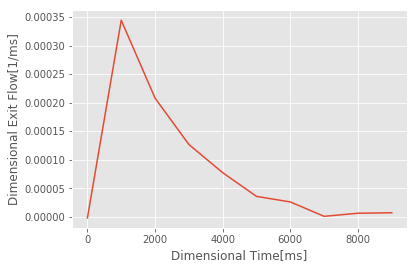

In [4]:
dimensional_time = np.zeros(data_points)
dimensional_exit_flow = np.zeros(data_points)
i = 0
j = 0
for line in open(data_file, "r"):
    if i%(10000/data_points)==0:
        data = line.split("\t")
        dimensional_time[j] = data[0]
        dimensional_exit_flow[j] = data[1]
        j += 1
    else:
        pass
    i += 1


print(len(dimensional_time), "\t", len(dimensional_exit_flow))
# print(dimensional_time, dimensional_exit_flow)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(dimensional_time, dimensional_exit_flow)

ax.set_xlabel('Dimensional Time[ms]')
ax.set_ylabel('Dimensional Exit Flow[1/ms]')

plt.show()

## モデル依存のサンプリング

\begin{align}
    P\left(I_{\mu}\right) &= \prod_{\mu=1}^{T}\left(\sqrt{\frac{\alpha+\beta}{\pi}}\exp\left(-\left(\alpha + \beta\right)\left\{I_{\mu}-\frac{\alpha I_{\mu}^{M=0}+\beta I_{\mu}^{M=1}}{\alpha + \beta}\right\}^2\right)\right) \\
    &= \prod_{\mu=1}^{T}\left(\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{1}{2\sigma^2}\left\{I_{\mu}-\left(1-M\right)I_{\mu}^{M=0}-MI_{\mu}^{M=1}\right\}^{2} \right) \right) \\
    &= \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^{T}\exp\left(-E\right) \\
    &= \exp\left(-E^{\prime}\right)
\end{align}

ただし
\begin{align}
    &\alpha = \frac{1-M}{2\sigma^{2}},\, 
    \beta = \frac{M}{2\sigma^{2}} \\
    E &= \frac{1}{2\sigma^{2}}\sum_{\mu=1}^{T}\left\{I_{\mu}-\left(1-M \right)I_{\mu}^{M=0}-MI_{\mu}^{M=1} \right\}^{2} \\
    E^{\prime} &= \frac{1}{2\sigma^{2}}\sum_{\mu=1}^{T}\left\{I_{\mu}-\left(1-M \right)I_{\mu}^{M=0}-MI_{\mu}^{M=1} \right\}^{2} + \frac{T}{2}\ln\left(2\pi\sigma^{2}\right)
\end{align}

$I_{\mu}$ は $F_{A}$

## 関数
```python:title
energy()
```
* 入力 : $M, D_{e}^{M=0}, D_{e}^{M=1}, k_{a}, k_{d}, \sigma$ ($\epsilon_{b}, L, t, F$ はあらかじめ指定)
* 出力 : 上記の $E^{\prime}$

In [5]:
def energy(model, diffusivity_0, diffusivity_1, k_a, k_d, std,
           epsilon=epsilon, length=length, 
           time=dimensional_time, artificial_flow=dimensional_exit_flow):

    
#    alpha = (1. - model)/(2.*std**2)
#    beta = model/(2.*std**2)
    
    Energy = np.square(artificial_flow - ((1.-model)*Flow(diffusivity=diffusivity_0,
                                                     k_a=0., k_d=0.,
                                                     epsilon=epsilon, length=length, 
                                                     time=time) + \
                                          model*Flow(diffusivity=diffusivity_1,
                                                     k_a=k_a, k_d=k_d, 
                                                     epsilon=epsilon, length=length, 
                                                     time=time))
                      ).sum()
    
    Energy *= 1./(2.*std**2)
    Energy += (time.shape[0]/2.) * np.log(2.*np.pi*std**2) 
    
    return Energy
        
#    return Energy, alpha, beta

#print(delta_energy(0, 1.5, 1.5, 20, 5, 5e-6, 5e-6))
#print(delta_energy(0.5, 1.5, 1.5, 20, 5, 5e-6, 5e-6))
print(energy(1, 1.5, 1.5, 20, 5, 5e-6))

-106.988904209


In [6]:
def energy_(model, diffusivity_0, diffusivity_1, k_a, k_d, std,
           epsilon=epsilon, length=length, 
           time=dimensional_time, artificial_flow=dimensional_exit_flow):
    
    I_M0 = Flow(diffusivity=diffusivity_0, k_a=0, k_d=0, epsilon=epsilon, length=length, time=time)
    I_M1 = Flow(diffusivity=diffusivity_1, k_a=k_a, k_d=k_d, epsilon=epsilon, length=length, time=time)
#     print(I_M0, I_M0.shape[0])
#     print(I_M1)
    Energy_ = np.zeros(time.shape[0])
    for i in range(time.shape[0]):
        Energy_[i] = artificial_flow[i] - (1-model)*I_M0[i] - model*I_M1[i]
        
#    print(Energy_)

    for i in range(time.shape[0]):
        Energy_[i] = Energy_[i]**2
        
#    print(Energy_)

    E_ = 0
    for i in range(time.shape[0]):
        E_ += Energy_[i]
        
    E_ /= 2.*(std**2)
    E_ += (time.shape[0]/2)*np.log(2.*np.pi*std**2)
    
    return E_

print(energy_(1, 1.5, 1.5, 20, 5, 5e-6))

-106.988904209


## 遷移確率

\begin{align}
    r &= \frac{\hat{e}_{\beta}}{e^{\left(t\right)}_{\beta}} \\
    &= \frac{\exp \left(-\beta {\hat{E^{\prime}}}\right)}{\exp\left(-\beta E^{\prime (t)}\right)}\\
    &= \exp\left(-\beta\left({\hat{E^{\prime}}}-E^{\prime (t)}\right)\right)
\end{align}

## 関数
```python:title
r()
```
* 入力 : $\beta, \hat{M}, M^{\left(t\right)}, \hat{D_{e}^{M=0}}, \hat{D_{e}^{M=1}}, \hat{k_{a}}, \hat{k_{d}}, \hat{\sigma}, D_{e}^{M=0, \left(t\right)}, D_{e}^{M=1, \left(t\right)}, k_{a}^{\left(t\right)}, k_{d}^{\left(t\right)}, \sigma^{\left(t\right)}$ ($\epsilon_{b}, L, t, F_{A}$ はあらかじめ指定)
* 出力 : 遷移確率 $r$, $\hat{E^{\prime}}, E^{\prime(t)}$

In [7]:
def r(beta, model_cand, model_current,
       diffusivity_0_cand, diffusivity_1_cand, k_a_cand, k_d_cand, std_cand,
       diffusivity_0_current, diffusivity_1_current, k_a_current, k_d_current, std_current, 
       epsilon=epsilon, length=length, 
       time=dimensional_time, artificial_flow=dimensional_exit_flow):
    
    E_cand = energy(model=model_cand,
                    diffusivity_0=diffusivity_0_cand,
                    diffusivity_1=diffusivity_1_cand,
                    k_a=k_a_cand, k_d=k_d_cand,
                    std=std_cand, 
                    epsilon=epsilon, length=length, 
                    time=time, artificial_flow=artificial_flow)
    
    E_current = energy(model=model_current, 
                       diffusivity_0=diffusivity_0_current,
                       diffusivity_1=diffusivity_1_current,
                       k_a=k_a_current, k_d=k_d_current,
                       std=std_current,
                       epsilon=epsilon, length=length, 
                       time=time, artificial_flow=artificial_flow)
    
    
    exponent = -E_cand + E_current
    
    return np.exp(beta*exponent), E_cand, E_current

# print(r(1, 1, 1, 1.5, 1.5, 20., 5., 5e-6, 1.5, 1.499, 20, 5, 5e-6))
print(r(0.2, 0.7, 0.7, 1.48, 1.49, 19.5, 5., 4.99e-6, 1.5001, 1.499, 20.02, 5.03, 5e-6))

(1.3149877878271676, 44.107517171884922, 45.476654065700714)


In [8]:
print(energy_(0.7, 1.48, 1.49, 19.5, 5., 4.99e-6), energy_(0.7, 1.5001, 1.499, 20.02, 5.03, 5e-6))

44.1075171719 45.4766540657


## 交換法

確率

\begin{align}
    r^{\prime} &= \frac{p^{M_{l}}_{\beta_{l}}\left(\hat{\theta}_{l+1}\right)p^{M_{l+1}}_{\beta_{l+1}}\left(\hat{\theta}_{l}\right)}{p^{M_{l}}_{\beta_{l}}\left(\hat{\theta}_{l}\right)p^{M_{l+1}}_{\beta_{l+1}}\left(\hat{\theta}_{l+1}\right)} \\
    &= \exp\left(-\beta_{l}E^{\prime}_{M_{l}}\left(\hat{\theta}_{l+1}\right)-\beta_{l+1}E^{\prime}_{M_{l+1}}\left(\hat{\theta}_{l}\right)+\beta_{l}E^{\prime}_{M_{l}}\left(\hat{\theta}_{l}\right)+\beta_{l+1}E^{\prime}_{M_{l+1}}\left(\hat{\theta}_{l+1}\right)\right)
\end{align}

でパラメータを交換

## 関数
```python;title
r_prime()
```
* 入力 : $\beta_l, \beta_{l+1}, M_{l}, D_{e, l}^{M=0}, D_{e, l}^{M=1}, k_{a, l}, k_{d, l}, \sigma_{l}, M_{l+1}, D_{e, l+1}^{M=0}, D_{e, l+1}^{M=1}, k_{a, l+1}, k_{d, l+1}, \sigma_{l+1}$ ($\epsilon_{b}, L, t, F$ はあらかじめ指定)
* 出力 : $r^{\prime}$

In [11]:
def r_prime(beta_l, beta_lplus1, model_l, diffusivity0_l, diffusivity1_l, k_a_l, k_d_l, std_l, 
            model_lplus1, diffusivity0_lplus1, diffusivity1_lplus1, k_a_lplus1, k_d_lplus1, std_lplus1, 
            epsilon=epsilon, length=length, time=dimensional_time, artificial_flow=dimensional_exit_flow):
    
    E1 = energy(model=model_l, diffusivity_0=diffusivity0_lplus1, diffusivity_1=diffusivity1_lplus1,
                k_a=k_a_lplus1, k_d=k_d_lplus1, std=std_lplus1,
                epsilon=epsilon, length=length,
                time=dimensional_time, artificial_flow=dimensional_exit_flow)
    
    E2 = energy(model=model_lplus1, diffusivity_0=diffusivity0_l, diffusivity_1=diffusivity1_l,
                k_a=k_a_l, k_d=k_d_l, std=std_l,
                epsilon=epsilon, length=length, 
                time=dimensional_time, artificial_flow=dimensional_exit_flow)
        
    E3 = energy(model=model_l, diffusivity_0=diffusivity0_l, diffusivity_1=diffusivity1_l,
                k_a=k_a_l, k_d=k_d_l, std=std_l,
                epsilon=epsilon, length=length, 
                time=dimensional_time, artificial_flow=dimensional_exit_flow)
        
    E4 = energy(model=model_lplus1, diffusivity_0=diffusivity0_lplus1, diffusivity_1=diffusivity1_lplus1,
                k_a=k_a_lplus1, k_d=k_d_lplus1, std=std_lplus1,
                epsilon=epsilon, length=length,
                time=dimensional_time, artificial_flow=dimensional_exit_flow)
    
#    print(E1, E2, E3, E4)
    
    E = -beta_l*E1-beta_lplus1*E2+beta_l*E3+beta_lplus1*E4
    
#    print(E)
    
    return np.exp(E)

print(r_prime(1, 1, 0.9, 1.5, 1.5, 20, 5, 5e-6, 1.0, 1.5, 1.49, 20, 5, 5e-6))

0.766404937781


In [10]:
def r_prime_(beta_l, beta_lplus1, model_l, diffusivity0_l, diffusivity1_l, k_a_l, k_d_l, std_l, 
            model_lplus1, diffusivity0_lplus1, diffusivity1_lplus1, k_a_lplus1, k_d_lplus1, std_lplus1, 
            epsilon=epsilon, length=length, time=dimensional_time, artificial_flow=dimensional_exit_flow):
    
#     bunsi1 = energy_(1.0, 1.5, 1.49, 20, 5, 5e-6)
#     bunsi2 = energy_(0.9, 1.5, 1.5, 20, 5, 5e-6)
#     bunbo1 = energy_(0.9, 1.5, 1.5, 20, 5, 5e-6)
#     bunbo2 = energy(1.0, 1.5, 1.49, 20, 5, 5e-6)

    bunsi1 = energy_(model_l, diffusivity0_lplus1, diffusivity1_lplus1, k_a_lplus1, k_d_lplus1, std_lplus1)
    bunsi2 = energy_(model_lplus1, diffusivity0_l, diffusivity1_l, k_a_l, k_d_l, std_l)
    bunbo1 = energy_(model_l, diffusivity0_l, diffusivity1_l, k_a_l, k_d_l, std_l)
    bunbo2 = energy_(model_lplus1, diffusivity0_lplus1, diffusivity1_lplus1, k_a_lplus1, k_d_lplus1, std_lplus1)
    
    print(bunsi1, bunsi2, bunbo1, bunbo2)
    
    E_ = -beta_l*bunsi1 - beta_lplus1*bunsi2 + beta_l*bunbo1 + beta_lplus1*bunbo2
    
    print(E_)
    
    return np.exp(E_)

print(r_prime_(1, 1, 0.9, 1.5, 1.5, 20, 5, 5e-6, 1.0, 1.5, 1.49, 20, 5, 5e-6))

-91.5153328496 -106.988904209 -91.7190957649 -107.051185903
-0.266044609522
0.766404937781


## 対数ベイズ因子の計算によるモデル選択

対数ベイズ因子は
\begin{align}
    \ln\frac{P\left(M=1\,|\,{\bf{F}}^{data}\right)}{P\left(M=0\,|\,{\bf{F}}^{data}\right)} = \
    \int_{0}^{1}dM\left\langle\frac{d\ln P\left({\bf{F}}^{data}\,|\,\theta, M\right)}{dM} \right\rangle_{M}
\end{align}

ただし被積分関数は

\begin{align}
    \left\langle\frac{d\ln P\left({\bf{F}}^{data}\,|\,\theta, M\right)}{dM} \right\rangle_{M} &= -\frac{d}{dM}E^{\prime} \\
    &= -\frac{1}{\sigma^{2}}\sum_{\mu=1}^{T}\left(I_{\mu}^{M=0}-I_{\mu}^{M=1}\right)\left\{I_{\mu}^{data}-\left(1-M\right)I_{\mu}^{M=0}-MI_{\mu}^{M=1}\right\}
\end{align}

と書ける。パラメータのサンプリング結果から被積分関数を数値的に求め，対数ベイズ因子を計算することによりモデル選択を行う。

## 対数ベイズ因子の被積分関数の計算
```python;title
dlog_p
```
* input : $M, D_e^{(M=0)}, D_e^{(M=1}, k_a, k_d, \sigma$ (全てスカラー)　
* output : 被積分関数 dlog (スカラー)

In [11]:
def dlog_p(model, diffusivity_0, diffusivity_1, k_a, k_d, 
           std, time=dimensional_time, artificial_flow=dimensional_exit_flow, 
           epsilon=epsilon, length=length):
    
    dlogp = -1./(std**2) \
            *(
                 (Flow(diffusivity=diffusivity_0, k_a=0, k_d=0, time=time, epsilon=epsilon, length=length) \
                  - Flow(diffusivity=diffusivity_1, k_a=k_a, k_d=k_d, time=time, epsilon=epsilon, length=length)) \
                 *(artificial_flow - (1-model)*Flow(diffusivity=diffusivity_0,
                                                    k_a=0, k_d=0,
                                                    time=time, epsilon=epsilon, length=length) \
                   - model*Flow(diffusivity=diffusivity_1, 
                                k_a=k_a, k_d=k_d, 
                                time=time, epsilon=epsilon, length=length)\
                   )
              ).sum()
           
    return dlogp

print(dlog_p(1, 1.49, 1.5, 20, 5, 5*10**-6))

-25.6943189783


In [18]:
def dlog_p_(model, diffusivity_0, diffusivity_1, k_a, k_d, 
           std, time=dimensional_time, artificial_flow=dimensional_exit_flow, 
           epsilo=epsilon, length=length):
    dlogp = 0.
    flow_0 = Flow(diffusivity=diffusivity_0, k_a=0, k_d=0, time=time, epsilon=epsilon, length=length)
    flow_1 = Flow(diffusivity=diffusivity_1, k_a=k_a, k_d=k_d, time=time, epsilon=epsilon, length=length)
    for t in range(time.shape[0]):
        dlogp += (flow_0[t]-flow_1[t])*(artificial_flow[t]-(1-model)*flow_0[t]-model*flow_1[t])
    dlogp *= -1./std**2
    
    return dlogp
    
print(dlog_p_(1, 1.49, 1.5, 20, 5, 5*10**-6))

-25.6943189783


エネルギーの収束を確認したい．そのためにまず$t_0=100$とし$2t_0$mcsまで計算する．$t_0$~$2t_0$の結果からエネルギーの0次モーメントと1次モーメントを評価する．

次に$2t_0$のときのパラメータ${\bf{\theta}}$の各値を初期値として，$4t_0$まで計算する．$2t_0$から$4t_0$までの結果(すなわち$2t_0$mcs)から再びモーメントを評価する．それを$t_0$~$2t_0$の結果と比較することで収束を確認する．

次に$4t_0$のときの${\bf{\theta}}$の各値を初期値として，$8t_0$まで計算する．$4t_0$から$8t_0$までの結果(すなわち$4t_0$mcs)を使ってモーメントを評価する．それを今まで計算したモーメント値と比較することで収束を確かめる．

以後，0次モーメントと1次モーメントが収束するまで同様の操作を帰納的に行う．以下のコードはそのためのアルゴリズムである．

## 交換法のアルゴリズム

```python;title
exchange_monte_calro()
```
* 入力 : モンテカルロステップ数，逆温度$\beta$，モデルパラメータ$M$, 各パラメータ$\theta$の初期値配列($\beta, M$は配列)
* 出力 : $D_e^{(M=0)}, D_e^{(M=1)}, k_a, k_d, \sigma, E^{\prime}, dlogp$　((`model.shape[0]`, $T$)の2次元配列), pick, update, exchange_rate

## アルゴリズムの変更点（2019年1月23日）

* `np.random.permutation`を使って交換順序をばらばらにした。
* MCMCの初期値を関数の引数から与えられるようにした⇒これによりMCMCを途中から走らせられることが可能になった。
* 計算した交換確率と乱数をみて${\bf{\theta}}$が交換しているか否か確認

In [12]:
# def exchange_monte_calro(monte_calro_step, beta, model, idiffusivity_0, idiffusivity_1,
#                          epsilon=epsilon, length=length,
#                          time=dimensional_time, artificial_flow=dimensional_exit_flow):
    
#     diffusivity_0 = np.zeros([2*beta.shape[0], monte_calro_step])
#     diffusivity_1 = np.zeros([2*beta.shape[0], monte_calro_step])
#     Energy = np.zeros([2*beta.shape[0], monte_calro_step])
#     pick = np.zeros([2*beta.shape[0], 5]); update = np.zeros([2*beta.shape[0], 5])
#     exchange_count = np.zeros(2*beta.shape[0]-1)
    
#     """initialize parameters"""
    
#     for i in range(2*beta.shape[0]):
#         diffusivity_0[i, 0] = idiffusivity_0[i]; diffusivity_1[i, 0] = idiffusivity_1[i]
#         if i < beta.shape[0]:
#             Energy[i, 0] = energy(0, diffusivity_0[i, 0], diffusivity_1[i, 0], 20., 5., 5e-6)
#         else:
#             Energy[i, 0] = energy(1, diffusivity_0[i, 0], diffusivity_1[i, 0], 20., 5., 5e-6)
# #    print(diffusivity_0, diffusivity_1)
    
#     t = 1

#     while t < monte_calro_step:
#         """update parameters"""
#         for b in range(2*beta.shape[0]):
#             diffusivity_0[b, t] = diffusivity_0[b, t-1]; diffusivity_1[b, t] = diffusivity_1[b, t-1]
#             Energy[b, t] = Energy[b, t-1]
            
#             choice = np.random.randint(0, 2); pick[b, choice] += 1
#             if choice == 0:
#                 diffusivity_0[b, t] += stats.uniform.rvs(loc=-1e-1, scale=2e-1)
#             elif choice == 1:
#                 diffusivity_1[b, t] += stats.uniform.rvs(loc=-1e-1, scale=2e-1)

#             if b+1 <= beta.shape[0]:
#                 model = 0
#                 inv_temp = beta[b]
#             else:
#                 model = 1
#                 inv_temp = beta[2*beta.shape[0]-1-b]
            
            
# #            print('model=',model, 'beta=', inv_temp)
#             transition_prob, e_cand, e_current = r(inv_temp, model, model,
#                                                    diffusivity_0[b, t], diffusivity_1[b, t],
#                                                    20., 5., 5e-6,
#                                                    diffusivity_0[b, t-1], diffusivity_1[b, t-1],
#                                                    20., 5., 5e-6)
            
#             if np.array([1.0, transition_prob]).min() > stats.uniform.rvs():
#                 Energy[b, t] = e_cand
#                 update[b, choice] += 1
#             else:
#                 diffusivity_0[b, t] = diffusivity_0[b, t-1]; diffusivity_1[b, t] = diffusivity_1[b, t-1]
                
# #        print('Energy=', Energy)
        
#         y = np.random.permutation(2*beta.shape[0]-1)
# #        print(y)
        
#         """exchange parameters"""
#         for b in y:
#             if b < beta.shape[0]-1:
#                 beta_l, beta_lplus1 = beta[b], beta[b+1]
#                 model_l, model_lplus1 = 0., 0.
#             elif b == beta.shape[0]-1:
#                 beta_l, beta_lplus1 = beta[b], beta[b]
#                 model_l, model_lplus1 = 0., 1.0
#             elif b > beta.shape[0]-1:
#                 beta_l, beta_lplus1 = beta[2*beta.shape[0]-1-b], beta[2*beta.shape[0]-1-b-1]
#                 model_l, model_lplus1 = 1.0, 1.0
                
# #            print('model_l=', model_l,'model_l+1=', model_lplus1,'beta_l=', beta_l, 'beta_l+1=', beta_lplus1)
            
#             exchange_prob = r_prime(beta_l, beta_lplus1,
#                                     model_l, diffusivity_0[b, t], diffusivity_1[b, t],
#                                     20., 5., 5e-6, 
#                                     model_lplus1, diffusivity_0[b+1, t], diffusivity_1[b+1, t],
#                                     20., 5., 5e-6)
            
#             #print(exchange_prob)
            
#             if np.array([1.0, exchange_prob]).min() > stats.uniform.rvs():
#                 diffusivity_0[b, t], diffusivity_0[b+1, t] = diffusivity_0[b+1, t], diffusivity_0[b, t]
#                 diffusivity_1[b, t], diffusivity_1[b+1, t] = diffusivity_1[b+1, t], diffusivity_1[b, t]
#                 Energy[b, t], Energy[b+1, t] = Energy[b+1, t], Energy[b, t]
#                 exchange_count[b] += 1
                
# #                print('Exchange:, Energy=', Energy)
 
#         t += 1
                
#     return diffusivity_0, diffusivity_1, Energy, pick, update, exchange_count

In [12]:
def exchange_monte_calro(monte_calro_step, beta, model, idiffusivity_0, idiffusivity_1, 
                         ik_a, ik_d, isigma,
                         epsilon=epsilon, length=length, 
                         time=dimensional_time, artificial_flow=dimensional_exit_flow):
    
    diffusivity_0 = np.zeros([2*beta.shape[0], monte_calro_step])
    diffusivity_1 = np.zeros([2*beta.shape[0], monte_calro_step])
    k_a = np.zeros([2*beta.shape[0], monte_calro_step])
    k_d = np.zeros([2*beta.shape[0], monte_calro_step])
    sigma = np.zeros([2*beta.shape[0], monte_calro_step])
    Energy = np.zeros([2*beta.shape[0], monte_calro_step])
    pick = np.zeros([2*beta.shape[0], 5]); update = np.zeros([2*beta.shape[0], 5])
    exchange_count = np.zeros(2*beta.shape[0]-1)
    
    """initialize parameters"""
    
    for i in range(2*beta.shape[0]):
        diffusivity_0[i, 0] = idiffusivity_0[i]; diffusivity_1[i, 0] = idiffusivity_1[i]
        k_a[i, 0] = ik_a[i]; k_d[i, 0] = ik_d[i]; sigma[i, 0] = isigma[i]
        if i < beta.shape[0]:
            Energy[i, 0] = energy(0, diffusivity_0[i, 0], diffusivity_1[i, 0], k_a[i, 0], k_d[i, 0], sigma[i, 0])
        else:
            Energy[i, 0] = energy(1, diffusivity_0[i, 0], diffusivity_1[i, 0], k_a[i, 0], k_d[i, 0], sigma[i, 0])
    
    t = 1

    while t < monte_calro_step:
        """update parameters"""
        for b in range(2*beta.shape[0]):
            diffusivity_0[b, t] = diffusivity_0[b, t-1]; diffusivity_1[b, t] = diffusivity_1[b, t-1]
            k_a[b, t] = k_a[b, t-1]; k_d[b, t] = k_d[b, t-1]; sigma[b, t] = sigma[b, t-1]
            Energy[b, t] = Energy[b, t-1]
            
            choice = np.random.randint(0, 5); pick[b, choice] += 1
            if choice == 0:
                diffusivity_0[b, t] += stats.uniform.rvs(loc=-1e-1, scale=2e-1)
            elif choice == 1:
                diffusivity_1[b, t] += stats.uniform.rvs(loc=-1e-1, scale=2e-1)
            elif choice == 2:
                k_a[b, t] += stats.uniform.rvs(loc=-1e-1, scale=2e-1)
            elif choice == 3:
                k_d[b, t] += stats.uniform.rvs(loc=-1e-1, scale=2e-1)
            elif choice == 4:
                sigma[b, t] += stats.uniform.rvs(loc=-1e-6, scale=2e-6)
            
            if b+1 <= beta.shape[0]:
                model = 0
                inv_temp = beta[b]
            else:
                model = 1
                inv_temp = beta[2*beta.shape[0]-1-b]
            
            
#            print('model=',model, 'beta=', inv_temp)
            transition_prob, e_cand, e_current = r(inv_temp, model, model,
                                                   diffusivity_0[b, t], diffusivity_1[b, t],
                                                   k_a[b, t], k_d[b, t], sigma[b, t],
                                                   diffusivity_0[b, t-1], diffusivity_1[b, t-1],
                                                   k_a[b, t-1], k_d[b, t-1], sigma[b, t-1])
            
            if np.array([1.0, transition_prob]).min() > stats.uniform.rvs():
                Energy[b, t] = e_cand
                update[b, choice] += 1
            else:
                diffusivity_0[b, t] = diffusivity_0[b, t-1]; diffusivity_1[b, t] = diffusivity_1[b, t-1]
                k_a[b, t] = k_a[b, t-1]; k_d[b, t] = k_d[b, t-1]; sigma[b, t] = sigma[b, t-1]
        
 #       print('Energy=', Energy)
        
        """exchange parameters"""
        y = np.random.permutation(2*beta.shape[0]-1)
  #      print(y)
        
        for b in y:
            if b < beta.shape[0]-1:
                beta_l, beta_lplus1 = beta[b], beta[b+1]
                model_l, model_lplus1 = 0., 0.
            elif b == beta.shape[0]-1:
                beta_l, beta_lplus1 = beta[b], beta[b]
                model_l, model_lplus1 = 0., 1.0
            elif b > beta.shape[0]-1:
                beta_l, beta_lplus1 = beta[2*beta.shape[0]-1-b], beta[2*beta.shape[0]-1-b-1]
                model_l, model_lplus1 = 1.0, 1.0
                
#            print('model_l=', model_l,'model_l+1=', model_lplus1, 'beta_l=', beta_l, 'beta_l+1', beta_lplus1)
            
            exchange_prob = r_prime(beta_l, beta_lplus1,
                                    model_l, diffusivity_0[b, t], diffusivity_1[b, t],
                                    k_a[b, t], k_d[b, t], sigma[b, t], 
                                    model_lplus1, diffusivity_0[b+1, t], diffusivity_1[b+1, t],
                                    k_a[b+1, t], k_d[b+1, t], sigma[b+1, t])
        
#            print('exchagne_prob=', exchange_prob)
            
            ransu = stats.uniform.rvs()
#            print('ransu=', ransu)
            
            if np.array([1.0, exchange_prob]).min() > ransu:#stats.uniform.rvs():
                diffusivity_0[b, t], diffusivity_0[b+1, t] = diffusivity_0[b+1, t], diffusivity_0[b, t]
                diffusivity_1[b, t], diffusivity_1[b+1, t] = diffusivity_1[b+1, t], diffusivity_1[b, t]
                k_a[b, t], k_a[b+1, t] = k_a[b+1, t], k_a[b, t]; k_d[b, t], k_d[b+1, t] = k_d[b+1, t], k_d[b, t]
                sigma[b, t], sigma[b+1, t] = sigma[b+1, t], sigma[b, t]
                Energy[b, t], Energy[b+1, t] = Energy[b+1, t], Energy[b, t]
                exchange_count[b] += 1
                
#                print('Exchange:, Energy=', Energy)
#                print('\n')
 
        t += 1
                
    return diffusivity_0, diffusivity_1, k_a, k_d, sigma, Energy, pick, update, exchange_count

In [15]:
%%time

id0 = np.full(2*beta.shape[0], 5, dtype=float)
id1 = np.full(2*beta.shape[0], 5, dtype=float)
ika = np.full(2*beta.shape[0], 10, dtype=float)
ikd = np.full(2*beta.shape[0], 10, dtype=float)
isig = np.full(2*beta.shape[0], 2e-6, dtype=float)

mcs = 5

d0, d1, ka, kd, s, e, pick, update, exchange_count = exchange_monte_calro(mcs, beta, [0, 1], id0, id1, ika, ikd, isig)

Wall time: 198 ms


C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


In [13]:
%%time

temp = np.array([1, 2])
beta = 1./temp
#print(beta)

mcs =200
id0 = np.full(2*beta.shape[0], 5, dtype=float)
id1 = np.full(2*beta.shape[0], 5, dtype=float)
ika = np.full(2*beta.shape[0], 10, dtype=float)
ikd = np.full(2*beta.shape[0], 10, dtype=float)
isig = np.full(2*beta.shape[0], 2e-6, dtype=float)

d0, d1, ka, kd, s, e, pick, update, exchange_count = exchange_monte_calro(mcs, beta, [0, 1], id0, id1, ika, ikd, isig)

C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


Wall time: 5.35 s


In [13]:
%%time

temp = np.array([1, 100])
beta = 1./temp

mcs = 25600
id0 = np.full(2*beta.shape[0], 5, dtype=float)
id1 = np.full(2*beta.shape[0], 5, dtype=float)
ika = np.full(2*beta.shape[0], 10, dtype=float)
ikd = np.full(2*beta.shape[0], 10, dtype=float)
isig = np.full(2*beta.shape[0], 2e-6, dtype=float)

d0_1, d1_1, ka_1, kd_1, s_1, e_1, pick_1, update_1, exchange_count_1 = exchange_monte_calro(mcs, beta, [0, 1], id0, id1, ika, ikd, isig)

C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in exp
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in add
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in multiply
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in square
  app.launch_new_instance()


Wall time: 24min 39s


In [14]:
%%time

#mcs =51200
id0 = np.full(2*beta.shape[0], 5, dtype=float)
id1 = np.full(2*beta.shape[0], 5, dtype=float)
ika = np.full(2*beta.shape[0], 10, dtype=float)
ikd = np.full(2*beta.shape[0], 10, dtype=float)
isig = np.full(2*beta.shape[0], 2e-6, dtype=float)

d0_2, d1_2, ka_2, kd_2, s_2, e_2, pick_2, update_2, exchange_count_2 = exchange_monte_calro(mcs, beta, [0, 1], id0, id1, ika, ikd, isig)

C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


Wall time: 26min 25s


In [15]:
%%time

#mcs =51200
id0 = np.full(2*beta.shape[0], 5, dtype=float)
id1 = np.full(2*beta.shape[0], 5, dtype=float)
ika = np.full(2*beta.shape[0], 10, dtype=float)
ikd = np.full(2*beta.shape[0], 10, dtype=float)
isig = np.full(2*beta.shape[0], 2e-6, dtype=float)

d0_3, d1_3, ka_3, kd_3, s_3, e_3, pick_3, update_3, exchange_count_3 = exchange_monte_calro(mcs, beta, [0, 1], id0, id1, ika, ikd, isig)

C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in exp
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in add
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in multiply


Wall time: 25min 43s


In [16]:
%%time

#mcs =51200
id0 = np.full(2*beta.shape[0], 5, dtype=float)
id1 = np.full(2*beta.shape[0], 5, dtype=float)
ika = np.full(2*beta.shape[0], 10, dtype=float)
ikd = np.full(2*beta.shape[0], 10, dtype=float)
isig = np.full(2*beta.shape[0], 2e-6, dtype=float)

d0_4, d1_4, ka_4, kd_4, s_4, e_4, pick_4, update_4, exchange_count_4 = exchange_monte_calro(mcs, beta, [0, 1], id0, id1, ika, ikd, isig)

C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in exp
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in add
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in multiply
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in square
  app.launch_new_instance()
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: overflow 

Wall time: 25min 44s


In [17]:
%%time

#mcs =51200
id0 = np.full(2*beta.shape[0], 5, dtype=float)
id1 = np.full(2*beta.shape[0], 5, dtype=float)
ika = np.full(2*beta.shape[0], 10, dtype=float)
ikd = np.full(2*beta.shape[0], 10, dtype=float)
isig = np.full(2*beta.shape[0], 2e-6, dtype=float)

d0_5, d1_5, ka_5, kd_5, s_5, e_5, pick_5, update_5, exchange_count_5 = exchange_monte_calro(mcs, beta, [0, 1], id0, id1, ika, ikd, isig)

C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in exp
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in add
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in multiply
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in square
  app.launch_new_instance()


Wall time: 25min 58s


In [18]:
Energy1 = np.zeros(8, dtype=float)
print(Energy1)

t0 = 100
start = t0
end = 2*t0

for i in range(Energy1.shape[0]):
    Energy1[i] = e_1[3, start:end].mean(axis=0)
    start = end
    end = 2*end
    print(start, end)
    
print(Energy1)

[ 0.  0.  0.  0.  0.  0.  0.  0.]
200 400
400 800
800 1600
1600 3200
3200 6400
6400 12800
12800 25600
25600 51200
[ 594.64224366   21.8994429   -73.29357565  -85.24728646  -90.73742056
  -90.60274528  -94.10987905 -105.42914783]


In [21]:
Energy2 = np.zeros(8, dtype=float)
Energy3 = np.zeros(8, dtype=float)
Energy4 = np.zeros(8, dtype=float)
Energy5 = np.zeros(8, dtype=float)

t0 = 100
start = t0
end = 2*t0

for i in range(Energy2.shape[0]):
    Energy2[i] = e_2[3, start:end].mean(axis=0)
    Energy3[i] = e_3[3, start:end].mean(axis=0)
    Energy4[i] = e_4[3, start:end].mean(axis=0)
    Energy5[i] = e_5[3, start:end].mean(axis=0)
    start = end
    end = 2*end

print(Energy2); print(Energy3); print(Energy4); print(Energy5)

Energy = np.zeros(8, dtype=float)
for i in range(Energy.shape[0]):
    Energy[i] = Energy1[i] + Energy2[i] + Energy3[i] + Energy4[i] + Energy5[i]
    Energy[i] /= 5
    
print(Energy)

[ 592.95212085   89.99570414  -63.18043925  -89.26971938  -97.14468148
 -104.87735549 -105.9095712  -105.62049689]
[ 717.53252789  119.85135181  -63.24449412  -85.40420207  -92.69771494
  -90.22109712 -103.36836554 -105.40710766]
[ 733.49166906  214.25250418  -39.93540757  -81.02125586  -90.99876753
 -102.99633831 -105.94042965 -105.76426968]
[ 444.02302575   55.0958704   -59.37099078  -91.39053411  -99.23344351
 -104.22354155 -104.16940089 -103.47245487]
[ 616.52831744  100.21897469  -59.80498147  -86.46659957  -94.1624056
  -98.58421555 -102.69952927 -105.13869539]


In [22]:
Energy_ = np.array([809.04190869, 74.0530032, -62.51794663, -87.44353551, -92.07133577, 
                  -99.35550161, -104.7222272, -105.21915275])
Energy_stand_dev_ = np.array([4.28675465e+02, 4.95078023e+01, 4.00782509e+00, 3.32210889e+00, 
                            3.08010633e+00, 3.96591504e+00, 8.55431734e-01, 3.54658151e-01])

Sigma_ = np.array([9.51312461e-06, 1.73167833e-05, 2.86057430e-05, 3.77823640e-05, 
                 3.73274993e-05, 1.86322145e-05, 7.70005524e-06, 7.14703462e-06])
Sigma_stand_dev_ = np.array([1.40238576e-06, 2.29656867e-06, 1.59883621e-06, 4.78970854e-06, 
                           9.26879005e-06, 8.62661164e-06, 1.01978839e-06, 2.08628583e-07])

In [4]:
Energy_non = np.array([576.91296064, 48.29297415, -66.92908721, -90.35940867, -99.80092947, -104.98868439, -105.54913588, 
                      -105.09786441, -105.22423269])
Energy_stand_dev_non = np.array([300.81145938, 48.07590203, 7.85706244, 4.89160079, 3.67279007, 1.43856314, 0.5725806, 
                                0.63224629, 0.57167949])

Sigma_non = np.array([9.83829791e-06, 1.75379598e-05, 2.78869927e-05, 3.18268096e-05, 1.98046051e-05, 8.28888638e-06, 6.82844408e-06, 
                     7.63783728e-06, 7.31906284e-06])
Sigma_stand_dev_non = np.array([1.59547696e-06, 2.01924842e-06, 2.75467250e-06, 5.69468718e-06, 7.33070042e-06, 2.33769097e-06, 
                               4.80185834e-07, 9.33027217e-07, 7.02368657e-07])

In [23]:
Energy_variance = np.zeros(8, dtype=float)
Energy_stand_dev = np.zeros(8, dtype=float)

for i in range(Energy_variance.shape[0]):
    Energy_variance[i] = (Energy1[i] - Energy[i])**2 + (Energy2[i] - Energy[i])**2 + (Energy3[i] - Energy[i])**2 + \
                    (Energy4[i] - Energy[i])**2 + (Energy5[i] - Energy[i])**2
    Energy_variance[i] /= 4.
    
Energy_stand_dev = np.sqrt(Energy_variance)
print(Energy_stand_dev)

[ 116.91363167   73.59285791   12.24902497    4.01153938    3.82406335
    7.49196324    4.92944621    0.94289993]


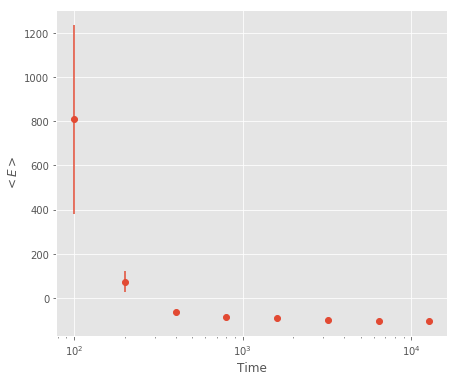

In [28]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800]), Energy, yerr=Energy_stand_dev, fmt='o')

ax.set_xlabel('Time')
ax.set_ylabel('$<E>$')

ax.set_xscale('log')

plt.legend(loc='upper left')

#plt.savefig('teireikai_20190206fig1_beta=1-M=1.png')

plt.show()

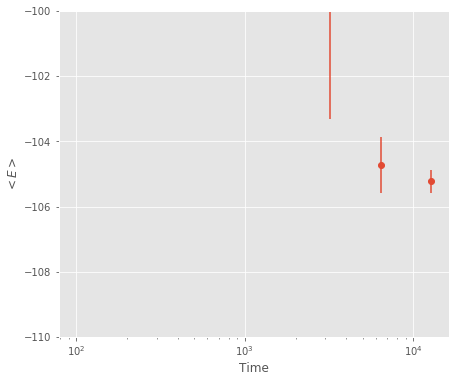

In [29]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800]), Energy, yerr=Energy_stand_dev, fmt='o')

ax.set_xlabel('Time')
ax.set_ylabel('$<E>$')

#ax.set_xlim(3000, 256800)
ax.set_ylim(-110, -100)

ax.set_xscale('log')

plt.legend(loc='upper left')

#plt.savefig('teireikai_20190206fig1.2_beta=1-M=1.png')

plt.show()

In [34]:
sigma1 = np.zeros(8, dtype=float)
sigma2 = np.zeros(8, dtype=float)
sigma3 = np.zeros(8, dtype=float)
sigma4 = np.zeros(8, dtype=float)
sigma5 = np.zeros(8, dtype=float)

t0 = 100
start = t0
end = 2*t0

for i in range(sigma1.shape[0]):
    sigma1[i] = s_2[3, start:end].mean(axis=0)
    sigma2[i] = s_2[3, start:end].mean(axis=0)
    sigma3[i] = s_3[3, start:end].mean(axis=0)
    sigma4[i] = s_4[3, start:end].mean(axis=0)
    sigma5[i] = s_5[3, start:end].mean(axis=0)
    start = end
    end = 2*end

Sigma = np.zeros(8, dtype=float)
for i in range(Energy.shape[0]):
    Sigma[i] = sigma1[i] + sigma2[i] + sigma3[i] + sigma4[i] + sigma5[i]
    Sigma[i] /= 5
    
print(Sigma)

[  9.91606499e-06   1.68856715e-05   2.93237897e-05   3.60463751e-05
   2.75587207e-05   1.62283952e-05   7.89533805e-06   7.15289164e-06]


In [35]:
Sigma_variance = np.zeros(8, dtype=float)
Sigma_stand_dev = np.zeros(8, dtype=float)

for i in range(Sigma_variance.shape[0]):
    Sigma_variance[i] = (sigma1[i] - Sigma[i])**2 + (sigma2[i] - Sigma[i])**2 + (sigma3[i] - Sigma[i])**2 + \
                    (sigma4[i] - Sigma[i])**2 + (sigma5[i] - Sigma[i])**2
    Sigma_variance[i] /= 4.
    
Sigma_stand_dev = np.sqrt(Sigma_variance)
print(Sigma_stand_dev)

[  7.58268896e-07   1.64494339e-06   2.00757748e-06   4.00689428e-06
   8.37395187e-06   1.64412434e-05   2.45544306e-06   1.14632682e-06]


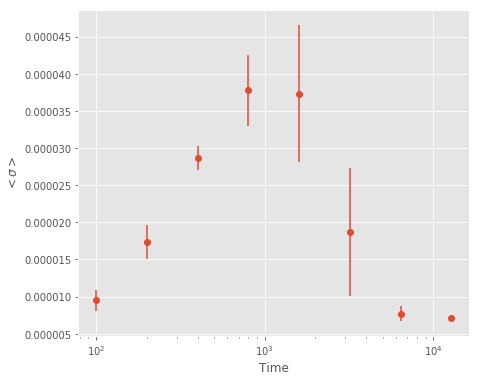

In [34]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800]), Sigma, yerr=Sigma_stand_dev, fmt='o')

ax.set_xlabel('Time')
ax.set_ylabel('$<\sigma>$')

ax.set_xscale('log')

plt.legend(loc='upper left')

#plt.savefig('teireikai_20190206fig2_beta=1-M=1.png')

plt.show()

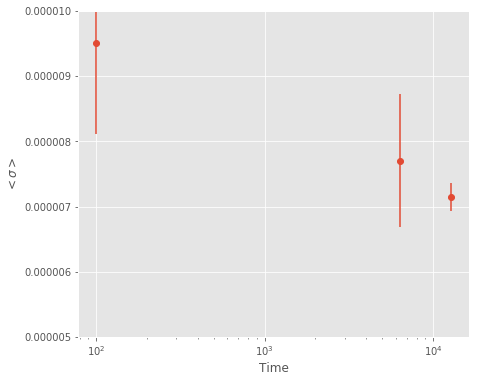

In [35]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800]), Sigma, yerr=Sigma_stand_dev, fmt='o')

ax.set_xlabel('Time')
ax.set_ylabel('$<\sigma>$')

#ax.set_xlim(3000, 256800)
ax.set_ylim(5e-6, 1e-5)

ax.set_xscale('log')

plt.legend(loc='upper left')

#plt.savefig('teireikai_20190206fig2.2_beta=1-M=1.png')

plt.show()

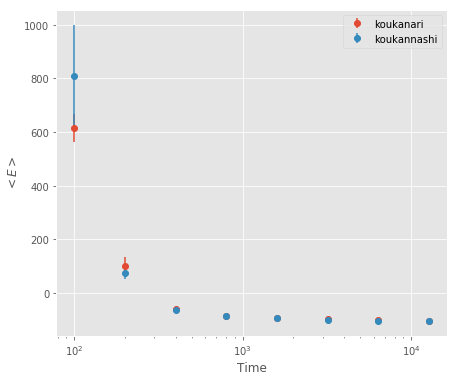

In [29]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800]), Energy, yerr=Energy_stand_dev/np.sqrt(5.), fmt='o', label='koukanari')
ax.errorbar(np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800]), Energy_, yerr=Energy_stand_dev_/np.sqrt(5.), fmt='o', label='koukannashi')


ax.set_xlabel('Time')
ax.set_ylabel('$<E>$')

ax.set_xscale('log')

plt.legend(loc='upper right')

#plt.savefig('teireikai_20190206fig5.1_beta=1-M=1.png')

plt.show()

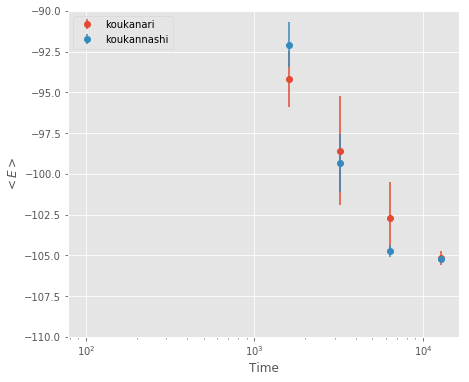

In [40]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800]), Energy, yerr=Energy_stand_dev/np.sqrt(5), fmt='o', label='koukanari')
ax.errorbar(np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800]), Energy_, yerr=Energy_stand_dev_/np.sqrt(5), fmt='o', label='koukannashi')

ax.set_xlabel('Time')
ax.set_ylabel('$<E>$')

#ax.set_xlim(3000, 256800)
ax.set_ylim(-110, -90)

ax.set_xscale('log')

plt.legend(loc='upper left')

#plt.savefig('teireikai_20190206fig5.2_beta=1-M=1.png')

plt.show()

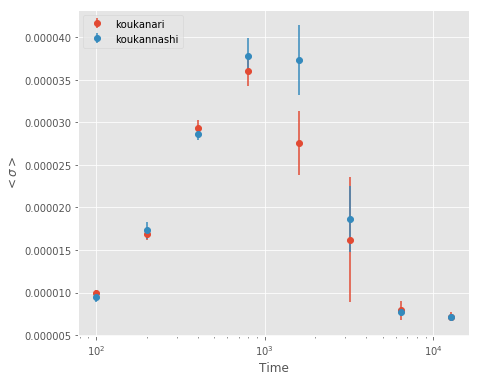

In [36]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800]), Sigma, yerr=Sigma_stand_dev/np.sqrt(5.), fmt='o', label='koukanari')
ax.errorbar(np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800]), Sigma_, yerr=Sigma_stand_dev_/np.sqrt(5.), fmt='o', label='koukannashi')

ax.set_xlabel('Time')
ax.set_ylabel('$<\sigma>$')

ax.set_xscale('log')

plt.legend(loc='upper left')

#plt.savefig('teireikai_20190206fig6.1_beta=1-M=1.png')

plt.show()

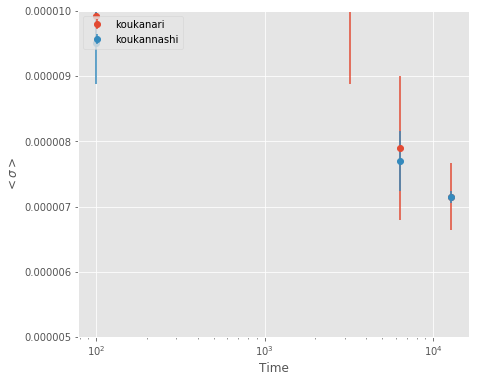

In [39]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800]), Sigma, yerr=Sigma_stand_dev/np.sqrt(5.), fmt='o', label='koukanari')
ax.errorbar(np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800]), Sigma_, yerr=Sigma_stand_dev_/np.sqrt(5.), fmt='o', label='koukannashi')

ax.set_xlabel('Time')
ax.set_ylabel('$<\sigma>$')

#ax.set_xlim(3000, 256800)
ax.set_ylim(5e-6, 1e-5)

ax.set_xscale('log')

plt.legend(loc='upper left')

#plt.savefig('teireikai_20190206fig6.2_beta=1-M=1.png')

plt.show()

In [43]:
print(exchange_count_1)
print(exchange_count_2)
print(exchange_count_3)
print(exchange_count_4)
print(exchange_count_5)

[    54.  22013.      0.]
[  7.00000000e+00   2.26610000e+04   7.00000000e+00]
[  6.00000000e+00   1.87640000e+04   1.40000000e+01]
[  4.00000000e+00   2.28040000e+04   3.00000000e+00]
[  4.35000000e+02   2.33450000e+04   3.00000000e+00]


In [24]:
Energy1 = np.zeros(9, dtype=float)
print(Energy1)

t0 = 100
start = t0
end = 2*t0

for i in range(Energy1.shape[0]):
    Energy1[i] = e_1[3, start:end].mean(axis=0)
    start = end
    end = 2*end
    print(start, end)
    
print(Energy1)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.]
200 400
400 800
800 1600
1600 3200
3200 6400
6400 12800
12800 25600
25600 51200
51200 102400
[ 313.1405299     2.39482342  -74.50234687  -93.47152674 -103.12898561
 -105.34045418 -105.89349115 -105.65174193 -105.27817451]


In [26]:
Energy2 = np.zeros(9, dtype=float)
Energy3 = np.zeros(9, dtype=float)
Energy4 = np.zeros(9, dtype=float)
Energy5 = np.zeros(9, dtype=float)

t0 = 100
start = t0
end = 2*t0

for i in range(Energy2.shape[0]):
    Energy2[i] = e_2[3, start:end].mean(axis=0)
    Energy3[i] = e_3[3, start:end].mean(axis=0)
    Energy4[i] = e_4[3, start:end].mean(axis=0)
    Energy5[i] = e_5[3, start:end].mean(axis=0)
    start = end
    end = 2*end

print(Energy2); print(Energy3); print(Energy4); print(Energy5)

Energy = np.zeros(9, dtype=float)
for i in range(Energy.shape[0]):
    Energy[i] = Energy1[i] + Energy2[i] + Energy3[i] + Energy4[i] + Energy5[i]
    Energy[i] /= 5
    
print(Energy)

[ 673.39948586   91.4540484   -55.20887048  -83.64962031  -98.16793454
 -105.11413863 -105.83332247 -104.95538379 -104.40828313]
[ 465.07174897   43.18160355  -70.93850823  -87.00748157  -94.12736922
 -102.51126302 -105.57865882 -104.19270464 -105.5784766 ]
[ 376.18241027    1.13527486  -71.24821191  -92.15780838 -102.02619201
 -106.00226468 -104.55127788 -104.93814692 -104.96445419]
[ 1056.77062822   103.29912054   -62.74749858   -95.51060636  -101.55416598
  -105.97530143  -105.88892907  -105.75134477  -105.89177501]
[ 576.91296064   48.29297415  -66.92908721  -90.35940867  -99.80092947
 -104.98868439 -105.54913588 -105.09786441 -105.22423269]


In [35]:
Energy_variance = np.zeros(9, dtype=float)
Energy_stand_dev = np.zeros(9, dtype=float)

for i in range(variance.shape[0]):
    Energy_variance[i] = (Energy1[i] - Energy[i])**2 + (Energy2[i] - Energy[i])**2 + (Energy3[i] - Energy[i])**2 + \
                    (Energy4[i] - Energy[i])**2 + (Energy5[i] - Energy[i])**2
    Energy_variance[i] /= 4.
    
Energy_stand_dev = np.sqrt(Energy_variance)
print(Energy_stand_dev)

[ 300.81145938   48.07590203    7.85706244    4.89160079    3.67279007
    1.43856314    0.5725806     0.63224629    0.57167949]


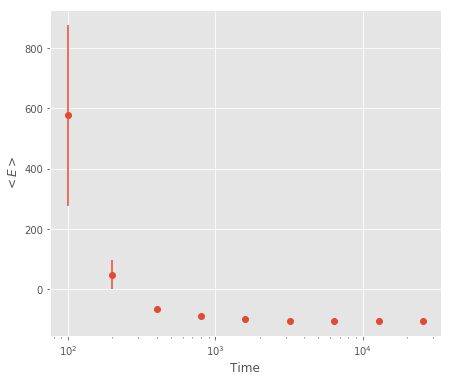

In [55]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]), Energy, yerr=Energy_stand_dev, fmt='o')

ax.set_xlabel('Time')
ax.set_ylabel('$<E>$')

ax.set_xscale('log')

plt.legend(loc='upper left')

#plt.savefig('teireikai_20190206fig1_beta=1-M=1.png')

plt.show()

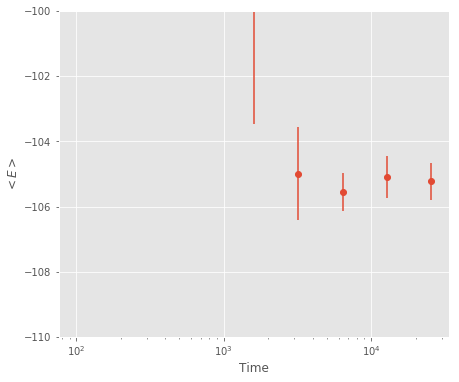

In [56]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]), Energy, yerr=Energy_stand_dev, fmt='o')

ax.set_xlabel('Time')
ax.set_ylabel('$<E>$')

#ax.set_xlim(3000, 256800)
ax.set_ylim(-110, -100)

ax.set_xscale('log')

plt.legend(loc='upper left')

#plt.savefig('teireikai_20190206fig1.2_beta=1-M=1.png')

plt.show()

In [38]:
sigma1 = np.zeros(9, dtype=float)
sigma2 = np.zeros(9, dtype=float)
sigma3 = np.zeros(9, dtype=float)
sigma4 = np.zeros(9, dtype=float)
sigma5 = np.zeros(9, dtype=float)

t0 = 100
start = t0
end = 2*t0

for i in range(sigma1.shape[0]):
    sigma1[i] = s_2[3, start:end].mean(axis=0)
    sigma2[i] = s_2[3, start:end].mean(axis=0)
    sigma3[i] = s_3[3, start:end].mean(axis=0)
    sigma4[i] = s_4[3, start:end].mean(axis=0)
    sigma5[i] = s_5[3, start:end].mean(axis=0)
    start = end
    end = 2*end

Sigma = np.zeros(9, dtype=float)
for i in range(Energy.shape[0]):
    Sigma[i] = sigma1[i] + sigma2[i] + sigma3[i] + sigma4[i] + sigma5[i]
    Sigma[i] /= 5
    
print(Sigma)

[  9.83829791e-06   1.75379598e-05   2.78869927e-05   3.18268096e-05
   1.98046051e-05   8.28888638e-06   6.82844408e-06   7.63783728e-06
   7.31906284e-06]


In [40]:
Sigma_variance = np.zeros(9, dtype=float)
Sigma_stand_dev = np.zeros(9, dtype=float)

for i in range(Sigma_variance.shape[0]):
    Sigma_variance[i] = (sigma1[i] - Sigma[i])**2 + (sigma2[i] - Sigma[i])**2 + (sigma3[i] - Sigma[i])**2 + \
                    (sigma4[i] - Sigma[i])**2 + (sigma5[i] - Sigma[i])**2
    Sigma_variance[i] /= 4.
    
Sigma_stand_dev = np.sqrt(Sigma_variance)
print(Sigma_stand_dev)

[  1.59547696e-06   2.01924842e-06   2.75467250e-06   5.69468718e-06
   7.33070042e-06   2.33769097e-06   4.80185834e-07   9.33027217e-07
   7.02368657e-07]


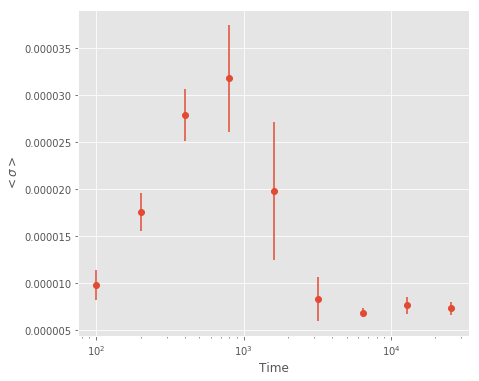

In [57]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]), Sigma, yerr=Sigma_stand_dev, fmt='o')

ax.set_xlabel('Time')
ax.set_ylabel('$<\sigma>$')

ax.set_xscale('log')

plt.legend(loc='upper left')

#plt.savefig('teireikai_20190206fig2_beta=1-M=1.png')

plt.show()

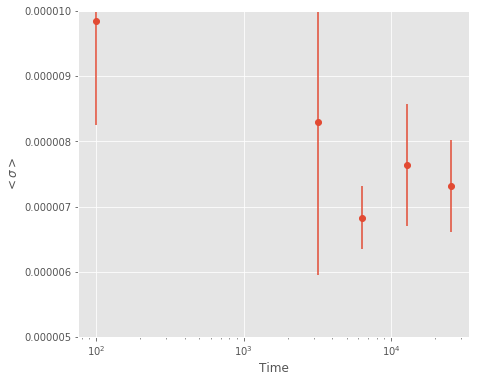

In [58]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]), Sigma, yerr=Sigma_stand_dev, fmt='o')

ax.set_xlabel('Time')
ax.set_ylabel('$<\sigma>$')

#ax.set_xlim(3000, 256800)
ax.set_ylim(5e-6, 1e-5)

ax.set_xscale('log')

plt.legend(loc='upper left')

#plt.savefig('teireikai_20190206fig2.2_beta=1-M=1.png')

plt.show()

In [47]:
Energy1_T2 = np.zeros(9, dtype=float)
Energy2_T2 = np.zeros(9, dtype=float)
Energy3_T2 = np.zeros(9, dtype=float)
Energy4_T2 = np.zeros(9, dtype=float)
Energy5_T2 = np.zeros(9, dtype=float)

t0 = 100
start = t0
end = 2*t0

for i in range(Energy1_T2.shape[0]):
    Energy1_T2[i] = e_1[2, start:end].mean(axis=0)
    Energy2_T2[i] = e_2[2, start:end].mean(axis=0)
    Energy3_T2[i] = e_3[2, start:end].mean(axis=0)
    Energy4_T2[i] = e_4[2, start:end].mean(axis=0)
    Energy5_T2[i] = e_5[2, start:end].mean(axis=0)
    start = end
    end = 2*end

#print(Energy2); print(Energy3); print(Energy4); print(Energy5)

Energy_T2 = np.zeros(9, dtype=float)
for i in range(Energy_T2.shape[0]):
    Energy_T2[i] = Energy1_T2[i] + Energy2_T2[i] + Energy3_T2[i] + Energy4_T2[i] + Energy5_T2[i]
    Energy_T2[i] /= 5
    
print(Energy_T2)

[ 722.36453526   90.15519926  -59.09477536  -81.11186105  -90.39276607
  -94.58109909  -97.50000671 -101.38646558 -103.30193642]


In [48]:
Energy_T2_variance = np.zeros(9, dtype=float)
Energy_T2_stand_dev = np.zeros(9, dtype=float)

for i in range(Energy_T2_variance.shape[0]):
    Energy_T2_variance[i] = (Energy1_T2[i] - Energy_T2[i])**2 + (Energy2_T2[i] - Energy_T2[i])**2\
                    + (Energy3_T2[i] - Energy_T2[i])**2 + \
                    (Energy4_T2[i] - Energy_T2[i])**2 + (Energy5_T2[i] - Energy_T2[i])**2
    Energy_T2_variance[i] /= 4.
    
Energy_T2_stand_dev = np.sqrt(Energy_T2_variance)
print(Energy_T2_stand_dev)

[ 252.74497684   60.31943888    5.81116802    4.81605118    6.66154934
    7.53120549    7.17841975    4.17840432    1.08557446]


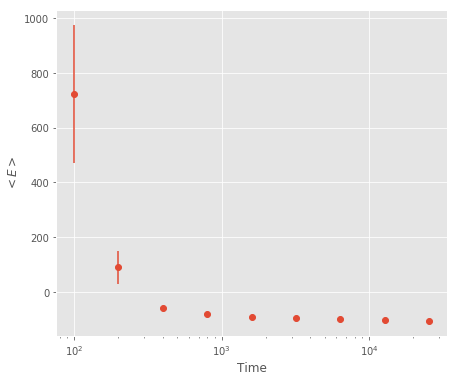

In [59]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]), Energy_T2, yerr=Energy_T2_stand_dev, fmt='o')

ax.set_xlabel('Time')
ax.set_ylabel('$<E>$')

ax.set_xscale('log')

plt.legend(loc='upper left')

#plt.savefig('teireikai_20190206fig3_beta=2-M=1.png')

plt.show()

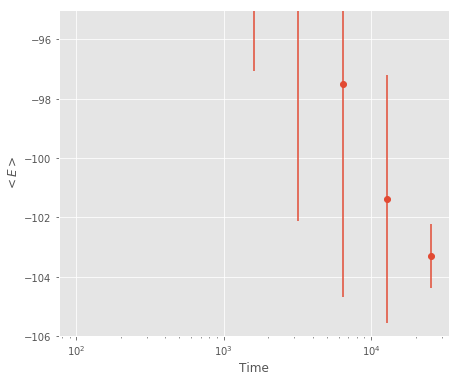

In [60]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]), Energy_T2, yerr=Energy_T2_stand_dev, fmt='o')

ax.set_xlabel('Time')
ax.set_ylabel('$<E>$')

#ax.set_xlim(3000, 256800)
ax.set_ylim(-106, -95)

ax.set_xscale('log')

plt.legend(loc='upper left')

#plt.savefig('teireikai_20190206fig3.2_beta=2-M=1.png')

plt.show()

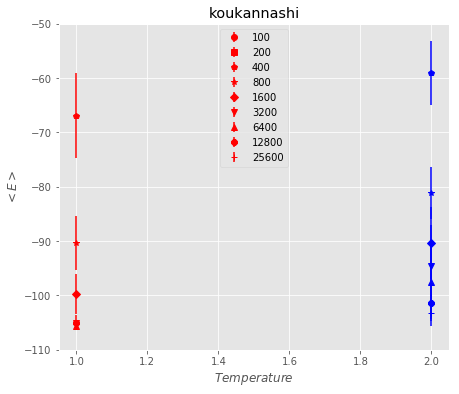

In [61]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

# ax.errorbar(np.array([1600, 3200, 6400, 12800, 25600]), energy_ave[2, 4:], yerr=energy_std[2, 4:], fmt='o', label='koukannashi,  M=1, beta=2')
# ax.errorbar(np.array([1600, 3200, 6400, 12800, 25600]), energy_ave_e[2, 4:], yerr=energy_std_e[2, 4:], fmt='o', label='koukanari,  M=1, beta=2')

colorlist = ['r', 'b']
markerlist = ['o', 's', 'p', '*', 'D', 'v', '^', '8', '+']
monteCarlo = np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600])

for i in range(Energy.shape[0]):
    ax.errorbar(np.array([1]), Energy[i], yerr=Energy_stand_dev[i], fmt='o', 
               marker=markerlist[i], color=colorlist[0], label='{}'.format(monteCarlo[i]))
    ax.errorbar(np.array([2]), Energy_T2[i], yerr=Energy_T2_stand_dev[i], fmt='o', 
               marker=markerlist[i], color=colorlist[1])

ax.set_xlabel('$Temperature$')
ax.set_ylabel('$<E>$')
ax.set_title('koukannashi')
ax.set_ylim(-110, -50)

#ax.set_xscale('log')

plt.legend(loc='upper center')

#plt.savefig('teireikai_20190206fig4_M=1.png')

plt.show()

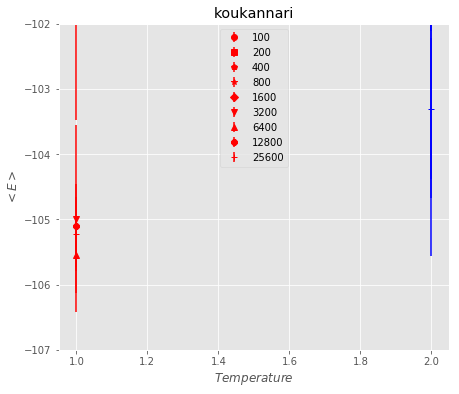

In [62]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

# ax.errorbar(np.array([1600, 3200, 6400, 12800, 25600]), energy_ave[2, 4:], yerr=energy_std[2, 4:], fmt='o', label='koukannashi,  M=1, beta=2')
# ax.errorbar(np.array([1600, 3200, 6400, 12800, 25600]), energy_ave_e[2, 4:], yerr=energy_std_e[2, 4:], fmt='o', label='koukanari,  M=1, beta=2')

colorlist = ['r', 'b']
markerlist = ['o', 's', 'p', '*', 'D', 'v', '^', '8', '+']
monteCarlo = np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600])

for i in range(Energy.shape[0]):
    ax.errorbar(np.array([1]), Energy[i], yerr=Energy_stand_dev[i], fmt='o', 
               marker=markerlist[i], color=colorlist[0], label='{}'.format(monteCarlo[i]))
    ax.errorbar(np.array([2]), Energy_T2[i], yerr=Energy_T2_stand_dev[i], fmt='o', 
               marker=markerlist[i], color=colorlist[1])

ax.set_xlabel('$Temperature$')
ax.set_ylabel('$<E>$')
ax.set_title('koukannari')
ax.set_ylim(-107, -102)

#ax.set_xscale('log')

plt.legend(loc='upper center')

plt.savefig('teireikai_20190206fig4.2_M=1.png')

plt.show()

In [15]:
print(e[:, 100:].mean(axis=1))
print(e[:, 100:].std(axis=1)/np.sqrt(100))

[ 1118.73503293  1665.15676121   599.43531738  3437.79181895]
[  46.66536649  107.39399017   21.23217488  317.24473146]


In [16]:
%%time

mcs = 200

d02, d12, ka2, kd2, s2, e2, pick2, update2, exchange_count2 = exchange_monte_calro(mcs, beta, [0, 1], d0[:, -1], d1[:, -1],
                                                                                  ka[:, -1], kd[:, -1], s[:, -1])

Wall time: 6.33 s


In [17]:
print(e2[:, :].mean(axis=1)[0])
print(e2[:, :].std(axis=1)[0]/np.sqrt(200))

298.255131871
12.6430780593


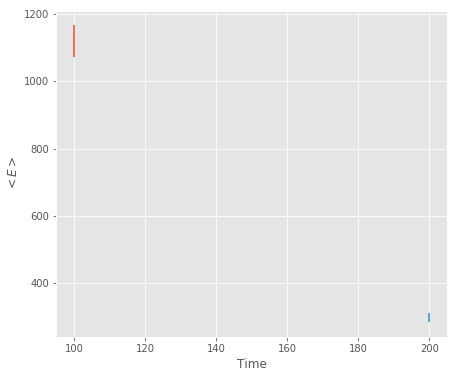

In [18]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(100, e[:, 100:].mean(axis=1)[0], e[:, 100:].std(axis=1)[0]/np.sqrt(100))
ax.errorbar(200, e2[:, ].mean(axis=1)[0], e2[:, ].std(axis=1)[0]/np.sqrt(200))

ax.set_xlabel('Time')
ax.set_ylabel('$<E>$')

plt.legend(loc='upper left')

plt.show()

In [19]:
D0 = np.concatenate([d0, d02], axis=1)
D1 = np.concatenate([d1, d12], axis=1)
Ka = np.concatenate([ka, ka2], axis=1)
Kd = np.concatenate([kd, kd2], axis=1)
Sigma = np.concatenate([s, s2], axis=1)
Energy = np.concatenate([e, e2], axis=1)

print(Energy.shape)

(4, 400)


In [20]:
%%time

mcs = 400

d0, d1, ka, kd, s, e, pick, update, exchange_count = exchange_monte_calro(mcs, beta, [0, 1], D0[:, -1], D1[:, -1],
                                                                                  Ka[:, -1], Kd[:, -1], Sigma[:, -1])

Wall time: 13.7 s


In [21]:
D0 = np.concatenate([D0, d0], axis=1)
D1 = np.concatenate([D1, d1], axis=1)
Ka = np.concatenate([Ka, ka], axis=1)
Kd = np.concatenate([Kd, kd], axis=1)
Sigma = np.concatenate([Sigma, s], axis=1)
Energy = np.concatenate([Energy, e], axis=1)

print(Energy.shape)

(4, 800)


In [22]:
energy_ave = np.zeros(3)
energy_std = np.zeros(3)

t0 = 100
start = t0
end = 2*t0

for i in range(energy_ave.shape[0]):
    energy_ave[i] = Energy[:, start:end].mean(axis=0)[0]
    energy_std[i] = Energy[:, start:end].std(axis=0)[0]/np.sqrt(start)
    start = end
    end = 2*end
    print(start, end)

200 400
400 800
800 1600


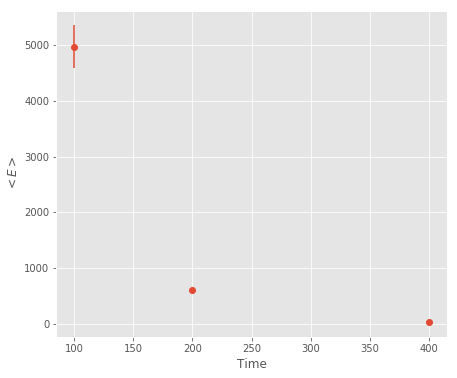

In [23]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([100, 200, 400]), energy_ave, yerr=energy_std, fmt='o')

ax.set_xlabel('Time')
ax.set_ylabel('$<E>$')

plt.legend(loc='upper left')

plt.show()

In [24]:
%%time

mcs = 800

d0, d1, ka, kd, s, e, pick, update, exchange_count = exchange_monte_calro(mcs, beta, [0, 1], D0[:, -1], D1[:, -1],
                                                                                  Ka[:, -1], Kd[:, -1], Sigma[:, -1])

Wall time: 24.5 s


In [25]:
D0 = np.concatenate([D0, d0], axis=1)
D1 = np.concatenate([D1, d1], axis=1)
Ka = np.concatenate([Ka, ka], axis=1)
Kd = np.concatenate([Kd, kd], axis=1)
Sigma = np.concatenate([Sigma, s], axis=1)
Energy = np.concatenate([Energy, e], axis=1)

print(Energy.shape)

(4, 1600)


In [26]:
energy_ave = np.zeros(4)
energy_std = np.zeros(4)

t0 = 100
start = t0
end = 2*t0

for i in range(energy_ave.shape[0]):
    energy_ave[i] = Energy[:, start:end].mean(axis=0)[0]
    energy_std[i] = Energy[:, start:end].std(axis=0)[0]/np.sqrt(start)
    start = end
    end = 2*end
    print(start, end)

200 400
400 800
800 1600
1600 3200


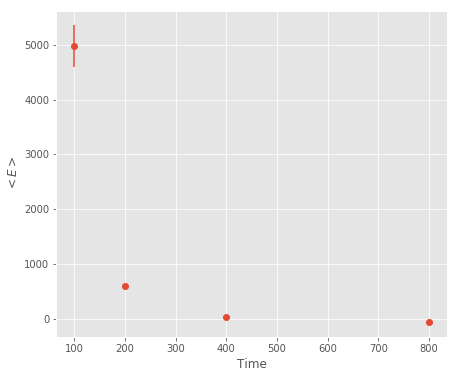

In [27]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([100, 200, 400, 800]), energy_ave, yerr=energy_std, fmt='o')

ax.set_xlabel('Time')
ax.set_ylabel('$<E>$')

plt.legend(loc='upper left')

plt.show()

In [28]:
%%time

mcs = 1600

d0, d1, ka, kd, s, e, pick, update, exchange_count = exchange_monte_calro(mcs, beta, [0, 1], D0[:, -1], D1[:, -1],
                                                                                  Ka[:, -1], Kd[:, -1], Sigma[:, -1])

Wall time: 45.8 s


In [29]:
D0 = np.concatenate([D0, d0], axis=1)
D1 = np.concatenate([D1, d1], axis=1)
Ka = np.concatenate([Ka, ka], axis=1)
Kd = np.concatenate([Kd, kd], axis=1)
Sigma = np.concatenate([Sigma, s], axis=1)
Energy = np.concatenate([Energy, e], axis=1)

print(Energy.shape)

(4, 3200)


In [30]:
energy_ave = np.zeros(5)
energy_std = np.zeros(5)

t0 = 100
start = t0
end = 2*t0

for i in range(energy_ave.shape[0]):
    energy_ave[i] = Energy[:, start:end].mean(axis=0)[0]
    energy_std[i] = Energy[:, start:end].std(axis=0)[0]/np.sqrt(start)
    start = end
    end = 2*end
    print(start, end)

200 400
400 800
800 1600
1600 3200
3200 6400


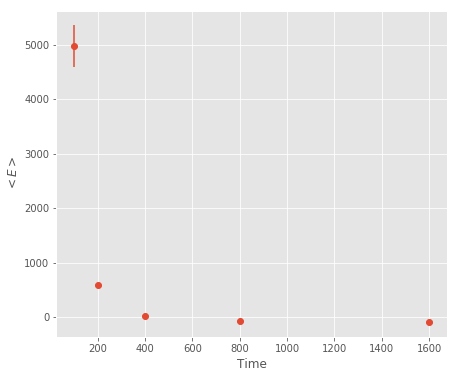

In [31]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([100, 200, 400, 800, 1600]), energy_ave, yerr=energy_std, fmt='o')

ax.set_xlabel('Time')
ax.set_ylabel('$<E>$')

plt.legend(loc='upper left')

plt.show()

In [32]:
%%time

mcs = 3200

d0, d1, ka, kd, s, e, pick, update, exchange_count = exchange_monte_calro(mcs, beta, [0, 1], D0[:, -1], D1[:, -1],
                                                                                  Ka[:, -1], Kd[:, -1], Sigma[:, -1])

Wall time: 1min 25s


In [33]:
D0 = np.concatenate([D0, d0], axis=1)
D1 = np.concatenate([D1, d1], axis=1)
Ka = np.concatenate([Ka, ka], axis=1)
Kd = np.concatenate([Kd, kd], axis=1)
Sigma = np.concatenate([Sigma, s], axis=1)
Energy = np.concatenate([Energy, e], axis=1)

print(Energy.shape)

(4, 6400)


In [34]:
energy_ave = np.zeros(6)
energy_std = np.zeros(6)

t0 = 100
start = t0
end = 2*t0

for i in range(energy_ave.shape[0]):
    energy_ave[i] = Energy[:, start:end].mean(axis=0)[0]
    energy_std[i] = Energy[:, start:end].std(axis=0)[0]/np.sqrt(start)
    start = end
    end = 2*end
    print(start, end)

200 400
400 800
800 1600
1600 3200
3200 6400
6400 12800


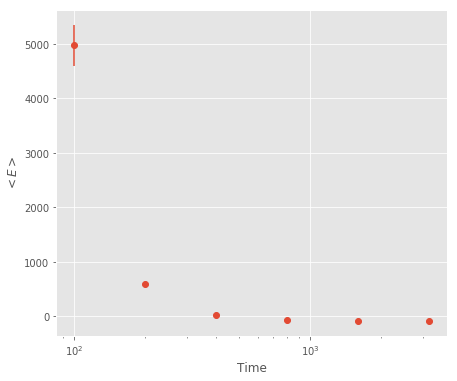

In [35]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([100, 200, 400, 800, 1600, 3200]), energy_ave, yerr=energy_std, fmt='o')

ax.set_xlabel('Time')
ax.set_ylabel('$<E>$')

ax.set_xscale('log')

plt.legend(loc='upper left')

plt.show()

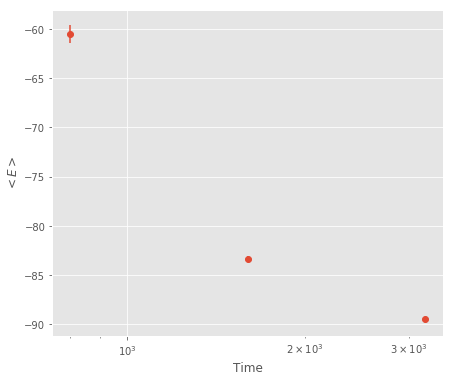

In [36]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([800, 1600, 3200]), energy_ave[3:], yerr=energy_std[3:], fmt='o')

ax.set_xlabel('Time')
ax.set_ylabel('$<E>$')

ax.set_xscale('log')

plt.legend(loc='upper left')

plt.show()

In [37]:
%%time

mcs = 6400

d0, d1, ka, kd, s, e, pick, update, exchange_count = exchange_monte_calro(mcs, beta, [0, 1], D0[:, -1], D1[:, -1],
                                                                                  Ka[:, -1], Kd[:, -1], Sigma[:, -1])

Wall time: 2min 59s


In [38]:
D0 = np.concatenate([D0, d0], axis=1)
D1 = np.concatenate([D1, d1], axis=1)
Ka = np.concatenate([Ka, ka], axis=1)
Kd = np.concatenate([Kd, kd], axis=1)
Sigma = np.concatenate([Sigma, s], axis=1)
Energy = np.concatenate([Energy, e], axis=1)

print(Energy.shape)

(4, 12800)


In [39]:
energy_ave = np.zeros(7)
energy_std = np.zeros(7)

t0 = 100
start = t0
end = 2*t0

for i in range(energy_ave.shape[0]):
    energy_ave[i] = Energy[:, start:end].mean(axis=0)[0]
    energy_std[i] = Energy[:, start:end].std(axis=0)[0]/np.sqrt(start)
    start = end
    end = 2*end
    print(start, end)

200 400
400 800
800 1600
1600 3200
3200 6400
6400 12800
12800 25600


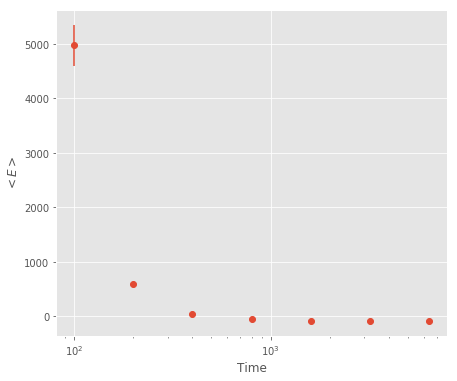

In [40]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([100, 200, 400, 800, 1600, 3200, 6400]), energy_ave, yerr=energy_std, fmt='o')

ax.set_xlabel('Time')
ax.set_ylabel('$<E>$')

ax.set_xscale('log')

plt.legend(loc='upper left')

plt.show()

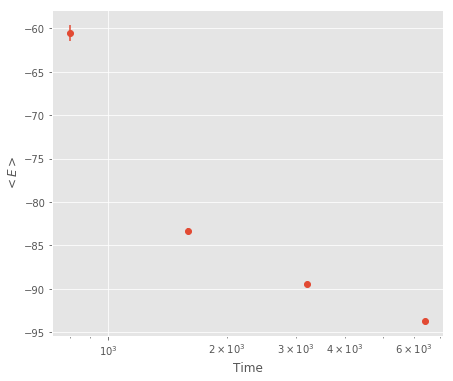

In [41]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([800, 1600, 3200, 6400]), energy_ave[3:], yerr=energy_std[3:], fmt='o')

ax.set_xlabel('Time')
ax.set_ylabel('$<E>$')

ax.set_xscale('log')

plt.legend(loc='upper left')

plt.show()

In [42]:
%%time

mcs = 12800

d0, d1, ka, kd, s, e, pick, update, exchange_count = exchange_monte_calro(mcs, beta, [0, 1], D0[:, -1], D1[:, -1],
                                                                                  Ka[:, -1], Kd[:, -1], Sigma[:, -1])

C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in exp
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in add
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in multiply


Wall time: 6min 1s


In [43]:
D0 = np.concatenate([D0, d0], axis=1)
D1 = np.concatenate([D1, d1], axis=1)
Ka = np.concatenate([Ka, ka], axis=1)
Kd = np.concatenate([Kd, kd], axis=1)
Sigma = np.concatenate([Sigma, s], axis=1)
Energy = np.concatenate([Energy, e], axis=1)

print(Energy.shape)

(4, 25600)


In [44]:
energy_ave = np.zeros(8)
energy_std = np.zeros(8)

t0 = 100
start = t0
end = 2*t0

for i in range(energy_ave.shape[0]):
    energy_ave[i] = Energy[:, start:end].mean(axis=0)[0]
    energy_std[i] = Energy[:, start:end].std(axis=0)[0]/np.sqrt(start)
    start = end
    end = 2*end
    print(start, end)

200 400
400 800
800 1600
1600 3200
3200 6400
6400 12800
12800 25600
25600 51200


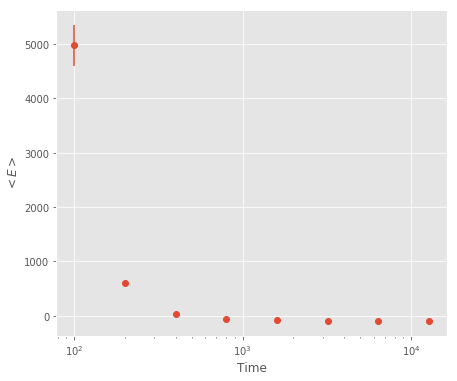

In [45]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800]), energy_ave, yerr=energy_std, fmt='o')

ax.set_xlabel('Time')
ax.set_ylabel('$<E>$')

ax.set_xscale('log')

plt.legend(loc='upper left')

plt.show()

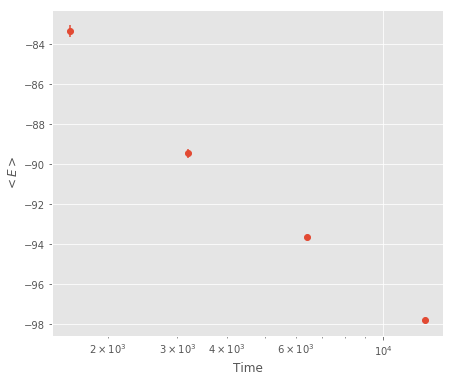

In [46]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([1600, 3200, 6400, 12800]), energy_ave[4:], yerr=energy_std[4:], fmt='o')

ax.set_xlabel('Time')
ax.set_ylabel('$<E>$')

ax.set_xscale('log')

plt.legend(loc='upper left')

plt.show()

In [47]:
%%time

mcs = 25600

d0, d1, ka, kd, s, e, pick, update, exchange_count = exchange_monte_calro(mcs, beta, [0, 1], D0[:, -1], D1[:, -1],
                                                                                  Ka[:, -1], Kd[:, -1], Sigma[:, -1])

C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in exp
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in add
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in multiply


Wall time: 14min 20s


In [48]:
D0 = np.concatenate([D0, d0], axis=1)
D1 = np.concatenate([D1, d1], axis=1)
Ka = np.concatenate([Ka, ka], axis=1)
Kd = np.concatenate([Kd, kd], axis=1)
Sigma = np.concatenate([Sigma, s], axis=1)
Energy = np.concatenate([Energy, e], axis=1)

print(Energy.shape)

(4, 51200)


In [49]:
energy_ave = np.zeros([4, 9])
energy_std = np.zeros([4, 9])

print(energy_ave.shape[0])
print(energy_ave.shape[1])

for i in range(energy_ave.shape[0]):
    t0 = 100
    start = t0
    end = 2*t0
    for j in range(energy_ave.shape[1]):
        energy_ave[i][j] = Energy[i, start:end].mean()
        energy_std[i][j] = Energy[i, start:end].std()/np.sqrt(start)
        start = end
        end = 2*end
#         print(start, end)

4
9


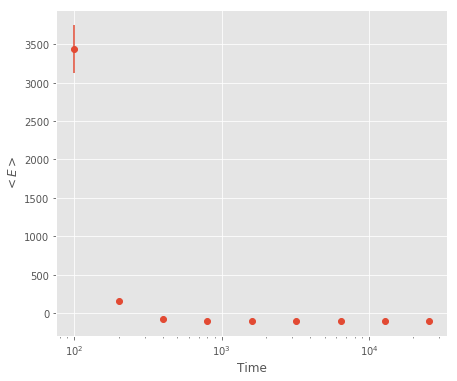

In [50]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]), energy_ave[3, ], yerr=energy_std[3, ], fmt='o')

ax.set_xlabel('Time')
ax.set_ylabel('$<E>$')

ax.set_xscale('log')

plt.legend(loc='upper left')

plt.show()

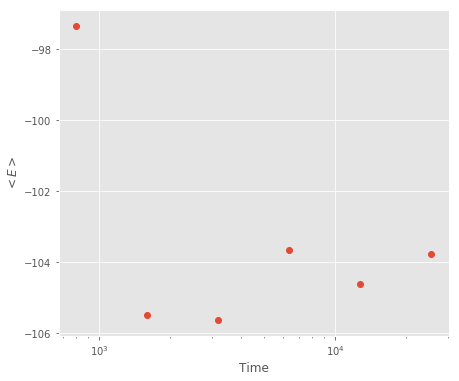

In [54]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([800, 1600, 3200, 6400, 12800, 25600]), energy_ave[3, 3:], yerr=energy_std[3, 3:], fmt='o')

ax.set_xlabel('Time')
ax.set_ylabel('$<E>$')

ax.set_xscale('log')

plt.legend(loc='upper left')

plt.show()

In [56]:
%%time

temp = np.array([1, 2])
beta = 1./temp
#print(beta)

mcs = 51200
id0 = np.full(2*beta.shape[0], 5, dtype=float)
id1 = np.full(2*beta.shape[0], 5, dtype=float)
ika = np.full(2*beta.shape[0], 10, dtype=float)
ikd = np.full(2*beta.shape[0], 10, dtype=float)
isig = np.full(2*beta.shape[0], 2e-6, dtype=float)

D0e, D1e, Kae, Kde, Sigmae, Energye, picke, updatee, exchange_counte = exchange_monte_calro(mcs, beta, [0, 1], id0, id1, ika, ikd, isig)

C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in exp
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in add
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: overflow encountered in multiply
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
C:\Users\anbaigashi\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: ov

Wall time: 57min 28s


In [57]:
energy_ave_e = np.zeros([4, 9])
energy_std_e = np.zeros([4, 9])

print(energy_ave_e.shape[0])
print(energy_ave_e.shape[1])

for i in range(energy_ave.shape[0]):
    t0 = 100
    start = t0
    end = 2*t0
    for j in range(energy_ave_e.shape[1]):
        energy_ave_e[i][j] = Energye[i, start:end].mean()
        energy_std_e[i][j] = Energye[i, start:end].std()/np.sqrt(start)
        start = end
        end = 2*end
#         print(start, end)

4
9


In [90]:
print(energy_ave)
print(energy_std)

[[  639.65378747   191.29796334     8.49701914   -49.3318454    -66.30424942
    -74.05271274   -86.84267195   -89.5666961    -95.90802572]
 [ 1846.46675722   450.59701407    57.6006437    -36.2859642    -59.73242456
    -70.55411239   -80.17509034   -79.82555629   -92.03990191]
 [ 1464.1158647    219.99506718   -25.16107499   -79.31291332
    -87.43160229   -85.14255998   -76.16269163   -79.07724967
    -80.02539538]
 [  569.88168692     4.72374797   -71.65936453   -96.42432004
   -100.95266914  -106.26022604  -106.01508654  -105.57453091
   -105.52711441]]
[[  3.41418735e+01   3.88555673e+00   1.30816077e+00   3.69030095e-01
    4.98303256e-02   9.98345604e-02   1.99438083e-02   3.04209966e-02
    8.86126681e-03]
 [  4.82297747e+01   1.84781957e+01   2.71844721e+00   3.65944991e-01
    1.03783477e-01   4.05863300e-02   7.36433788e-02   4.83714516e-02
    3.13299847e-02]
 [  7.49039456e+01   7.90836705e+00   1.95440458e+00   1.93625889e-01
    7.58132805e-02   1.12699641e-01   6.88188

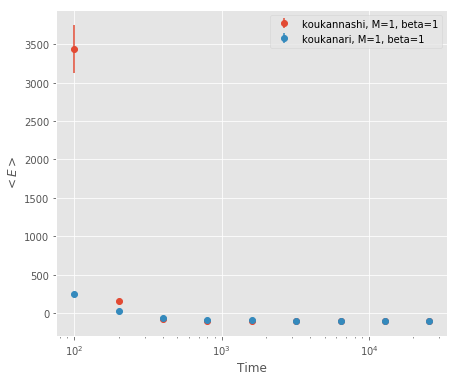

In [94]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]), energy_ave[3, ], yerr=energy_std[3, ], fmt='o', label='koukannashi, M=1, beta=1')
ax.errorbar(np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]), energy_ave_e[3, ], yerr=energy_std_e[3, ], fmt='o', label='koukanari, M=1, beta=1')


ax.set_xlabel('Time')
ax.set_ylabel('$<E>$')

ax.set_xscale('log')

plt.legend(loc='upper right')

plt.savefig('teireikai20190130fig1.png')

plt.show()

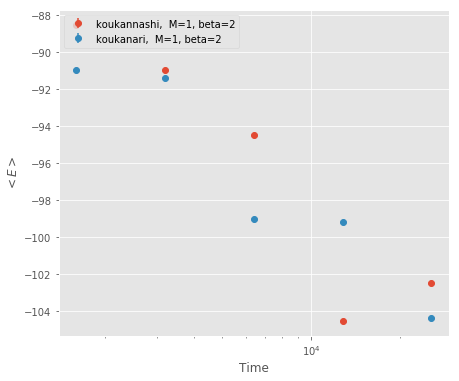

In [69]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([1600, 3200, 6400, 12800, 25600]), energy_ave[2, 4:], yerr=energy_std[2, 4:], fmt='o', label='koukannashi,  M=1, beta=2')
ax.errorbar(np.array([1600, 3200, 6400, 12800, 25600]), energy_ave_e[2, 4:], yerr=energy_std_e[2, 4:], fmt='o', label='koukanari,  M=1, beta=2')

ax.set_xlabel('Time')
ax.set_ylabel('$<E>$')

ax.set_xscale('log')

plt.legend(loc='upper left')

#plt.savefig('teireikai20190130fig4.png')

plt.show()

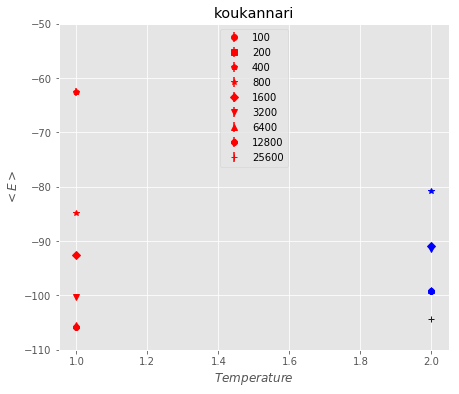

In [93]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

# ax.errorbar(np.array([1600, 3200, 6400, 12800, 25600]), energy_ave[2, 4:], yerr=energy_std[2, 4:], fmt='o', label='koukannashi,  M=1, beta=2')
# ax.errorbar(np.array([1600, 3200, 6400, 12800, 25600]), energy_ave_e[2, 4:], yerr=energy_std_e[2, 4:], fmt='o', label='koukanari,  M=1, beta=2')

colorlist = ['r', 'b']
markerlist = ['o', 's', 'p', '*', 'D', 'v', '^', '8', '+']
monteCarlo = np.array([100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200])

for i in range(energy_ave.shape[1]):
    ax.errorbar(np.array([1]), energy_ave_e[3, i], yerr=energy_std_e[3, i], fmt='o', 
               marker=markerlist[i], color=colorlist[0], label='{}'.format(monteCarlo[i]))
    ax.errorbar(np.array([2]), energy_ave_e[2, i], yerr=energy_std_e[2, i], fmt='o', 
               marker=markerlist[i], color=colorlist[1])

ax.set_xlabel('$Temperature$')
ax.set_ylabel('$<E>$')
ax.set_title('koukannari')
ax.set_ylim(-110, -50)

#ax.set_xscale('log')

plt.legend(loc='upper center')

#plt.savefig('teireikai20190130fig8.png')

plt.show()

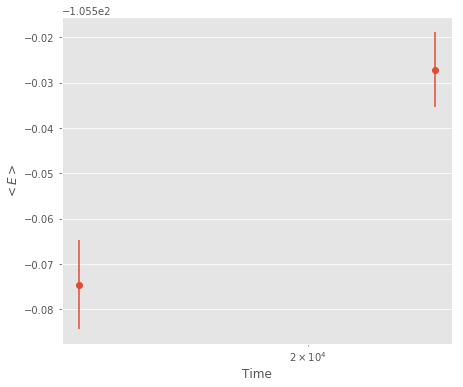

In [94]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.errorbar(np.array([12800, 25600]), energy_ave[3, 7:], yerr=energy_std[3, 7:], fmt='o')

ax.set_xlabel('Time')
ax.set_ylabel('$<E>$')

ax.set_xscale('log')

plt.legend(loc='upper left')

plt.show()

In [80]:
print(energy_ave)
print(energy_std)

[ 2064.51952692   588.83547831    70.34902772   -48.44366161   -73.26806219
   -82.80110879   -84.67372331   -89.26846386   -91.1076872 ]
[  7.92375083e+01   3.17024891e+01   4.06964431e+00   1.05933225e+00
   4.36218713e-01   2.97586739e-01   1.79242324e-01   1.00859526e-01
   7.42759369e-02]


In [96]:
print(D0[:, -1])
print(D1[:, -1])
print(Ka[:, -1])
print(Kd[:, -1])
print(Sigma[:, -1])
print(Energy[:, -1])

[  0.21298616   0.25066954   2.8858777   12.07852848]
[ 3.3433355   4.49449171  0.60424649  0.88696682]
[ 16.19676942  11.24003015  14.71964574  13.34072091]
[ 17.20768972  -0.44813407   4.93694825   6.86244803]
[  2.71179119e-05   4.31171411e-05   1.33730940e-04   5.39438921e-06]
[ -93.24412872  -90.75814652  -79.07215316 -107.15969536]


In [95]:
print(energy(1, 1.5, 1.5, 20, 5, 5e-6))

-106.988904209


In [53]:
def file_write(w_file, beta, model, diffusivity_0, diffusivity_1, k_a, k_d, sigma, E, dlogp, pick, update, exchange):
    
    with open(w_file, "w") as fileobj:
                
        fileobj.write(str('#model parametes M, temperature \n'))
        for i in range(model.shape[0]):
            for j in range(beta.shape[0]):
                if i==0 and j==0:
                    fileobj.write('#(M, Temp)=({}, {})'.format(model[i], temp[j])); fileobj.write(str('\t'))
                elif i==0:
                    fileobj.write('({}, {})'.format(model[i], temp[j])); fileobj.write(str('\t'))
                elif i==1:
                    fileobj.write('({}, {})'.format(model[i], temp[beta.shape[0]-1-j])); fileobj.write(str('\t'))
        fileobj.write(str('\n \n'))

        fileobj.write(str("#acceptance rate\n"))
        for m in range(2*beta.shape[0]):
            for i in range(5):
                fileobj.write(str(pick[m, i])); fileobj.write(str("\t"))
            fileobj.write(str("\n"))
        fileobj.write(str("\n"))
        fileobj.write(str('#update \n'))
        for m in range(2*beta.shape[0]):
            for i in range(5):
                fileobj.write(str(update[m, i])); fileobj.write(str("\t"))
            fileobj.write(str("\n"))
        fileobj.write(str("\n"))

        fileobj.write(str("#exchange rate\n"))
        for m in range(2*beta.shape[0]-1):
            fileobj.write(str(exchange[m])); fileobj.write(str("\t"))
        fileobj.write(str("\n")); fileobj.write(str("\n"))

        fileobj.write(str('De^M=0, De^M=1, ka, kd, sigma, energy, log bayes f\n'))
        for b in range(2*beta.shape[0]):
            if b < beta.shape[0]:
                fileobj.write(str("#M={}, beta={}\n".format(0, beta[b])))
            else:
                fileobj.write(str("#M={}, beta={}\n".format(1, beta[2*beta.shape[0]-1-b])))
            for i in range(T):
                fileobj.write(str(diffusivity_0[b, i])); fileobj.write(str("\t"))
                fileobj.write(str(diffusivity_1[b, i])); fileobj.write(str("\t"))
                fileobj.write(str(k_a[b, i])); fileobj.write(str("\t"))
                fileobj.write(str(k_d[b, i])); fileobj.write(str("\t"))
                fileobj.write(str(sigma[b, i])); fileobj.write(str("\t"))
                fileobj.write(str(E[b, i])); fileobj.write(str("\t"))
                fileobj.write(str(dlogp[b, i])); fileobj.write(str("\t"))
                fileobj.write(str("\n"))
            fileobj.write(str("\n"))
            
    return

In [54]:
dlogp = np.zeros([2*beta.shape[0], T])#######################

for i in range(sample):
#    w_file = 'EM_TAP_test_M11_sigma_{}.dat'.format(i)
#    diffusivity_0, diffusivity_1, k_a, k_d, sigma, E, pick, update, exchange\
#    = exchange_monte_calro(T, beta, [0, 1])
    
#    file_write(w_file, beta, np.array([0, 1]), diffusivity_0, diffusivity_1, k_a, k_d, sigma, E, dlogp, pick, update, exchange)